# A Simple Cohort Retention Analysis in PyMC

In this notebook we present a simple approach to study cohort retention analysis through a simulated data set. The aim is to understand how retention rates change over time and provide a simple model to predict them (with uncertainty estimates!). We do not expect this technique to be a silver bullet for all retention problems, but rather a simple approach to get started with the problem.

**Remark:** A motivation for this notebook was the great post *[Bayesian Age/Period/Cohort Models in Python with PyMC](https://www.austinrochford.com/posts/apc-pymc.html)* by [Austin Rochford](https://www.austinrochford.com/about.html).

## Prepare Notebook

In [29]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import numpy.typing as npt
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from scipy.special import expit
from sklearn.preprocessing import LabelEncoder, StandardScaler



az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data

In this section we generate some synthetic retention data. We assume we are interested in monthly retention rates. Here is the logic behind the data generation process: For a given month, say `2020-01`, we acquired $100$ users from which $20$ returned back (say, did a purchase) in `2020-02`. The retention rate for `2020-02` for the `2020-01` cohort is then $20/100 = 0.2$. We simulate cohort retention rates based on the following assumptions:

  * The retention rate is a function of the *cohort age* (i.e. how many months the cohort has been alive) and the *absolute age* (i.e. how many months have passed since the first month of the cohort since today).
  * The retention rate has a yearly seasonality component and a trend component.

We do not simulate retention rates directly but rather the number of users that returned back in a given month. We use a [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) for this purpose.

The following `CohortDataGenerator` class implements the data generation process.

In [30]:
class CohortDataGenerator:
    def __init__(
        self,
        rng: np.random.Generator,
        start_cohort: str,
        n_cohorts,
        user_base: int = 10_000,
    ) -> None:
        self.rng = rng
        self.start_cohort = start_cohort
        self.n_cohorts = n_cohorts
        self.user_base = user_base

    def _generate_cohort_labels(self) -> pd.DatetimeIndex:
        return pd.period_range(
            start="2020-01-01", periods=self.n_cohorts, freq="M"
        ).to_timestamp()

    def _generate_cohort_sizes(self) -> npt.NDArray[np.int_]:
        ones = np.ones(shape=self.n_cohorts)
        trend = ones.cumsum() / ones.sum()
        return (
            (
                self.user_base
                * trend
                * self.rng.gamma(shape=1, scale=1, size=self.n_cohorts)
            )
            .round()
            .astype(int)
        )

    def _generate_dataset_base(self) -> pd.DataFrame:
        cohorts = self._generate_cohort_labels()
        n_users = self._generate_cohort_sizes()
        data_df = pd.merge(
            left=pd.DataFrame(data={"cohort": cohorts, "n_users": n_users}),
            right=pd.DataFrame(data={"period": cohorts}),
            how="cross",
        )
        data_df["age"] = (data_df["period"].max() - data_df["cohort"]).dt.days
        data_df["cohort_age"] = (data_df["period"] - data_df["cohort"]).dt.days
        data_df = data_df.query("cohort_age >= 0")
        return data_df

    def _generate_retention_rates(self, data_df: pd.DataFrame) -> pd.DataFrame:
        data_df["retention_true_mu"] = (
            -data_df["cohort_age"] / (data_df["age"] + 1)
            + 0.8 * np.cos(2 * np.pi * data_df["period"].dt.dayofyear / 365)
            + 0.5 * np.sin(2 * 3 * np.pi * data_df["period"].dt.dayofyear / 365)
            - 0.5 * np.log1p(data_df["age"])
            + 1.0
        )
        data_df["retention_true"] = expit(data_df["retention_true_mu"])
        return data_df

    def _generate_user_history(self, data_df: pd.DataFrame) -> pd.DataFrame:
        data_df["n_active_users"] = self.rng.binomial(
            n=data_df["n_users"], p=data_df["retention_true"]
        )
        data_df["n_active_users"] = np.where(
            data_df["cohort_age"] == 0, data_df["n_users"], data_df["n_active_users"]
        )
        return data_df

    def run(
        self,
    ) -> pd.DataFrame:
        return (
            self._generate_dataset_base()
            .pipe(self._generate_retention_rates)
            .pipe(self._generate_user_history)
        )

Let's generate the data for $48$ cohorts.

In [31]:
seed: int = sum(map(ord, "retention"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

start_cohort: str = "2020-01-01"
n_cohorts: int = 48


cohort_generator = CohortDataGenerator(
    rng=rng, start_cohort=start_cohort, n_cohorts=n_cohorts
)
data_df = cohort_generator.run()

# calculate retention rates
data_df["retention"] = data_df["n_active_users"] / data_df["n_users"]

data_df.head()


cohort  n_users     period   age  cohort_age  retention_true_mu  \
0 2020-01-01      150 2020-01-01  1430           0          -1.807373   
1 2020-01-01      150 2020-02-01  1430          31          -1.474736   
2 2020-01-01      150 2020-03-01  1430          60          -2.281286   
3 2020-01-01      150 2020-04-01  1430          91          -3.206610   
4 2020-01-01      150 2020-05-01  1430         121          -3.112983   

   retention_true  n_active_users  retention  
0        0.140956             150   1.000000  
1        0.186224              25   0.166667  
2        0.092685              13   0.086667  
3        0.038918               6   0.040000  
4        0.042575               2   0.013333

In [32]:
# Save data to CSV
data_df.to_csv("../data/retention_data.csv", index=False)

Now we do a train test split to evaluate our model out-of-sample predictions.

In [33]:
period_train_test_split = "2022-11-01"

train_data_df = data_df.query("period <= @period_train_test_split")
test_data_df = data_df.query("period > @period_train_test_split")
test_data_df = test_data_df[
    test_data_df["cohort"].isin(train_data_df["cohort"].unique())
]


## EDA

Now, let's have a look at the data. We restrict ourselves to the training data as we really want to use the test data as a hold-out-set. First, we plot the number of users per cohort and the number of users that returned back per cohort.

[Text(0.5, 1.0, 'Number of active users per cohort (log scale)'),
 Text(0.5, 0, 'period'),
 Text(0, 0.5, 'number of active users'),
 None]

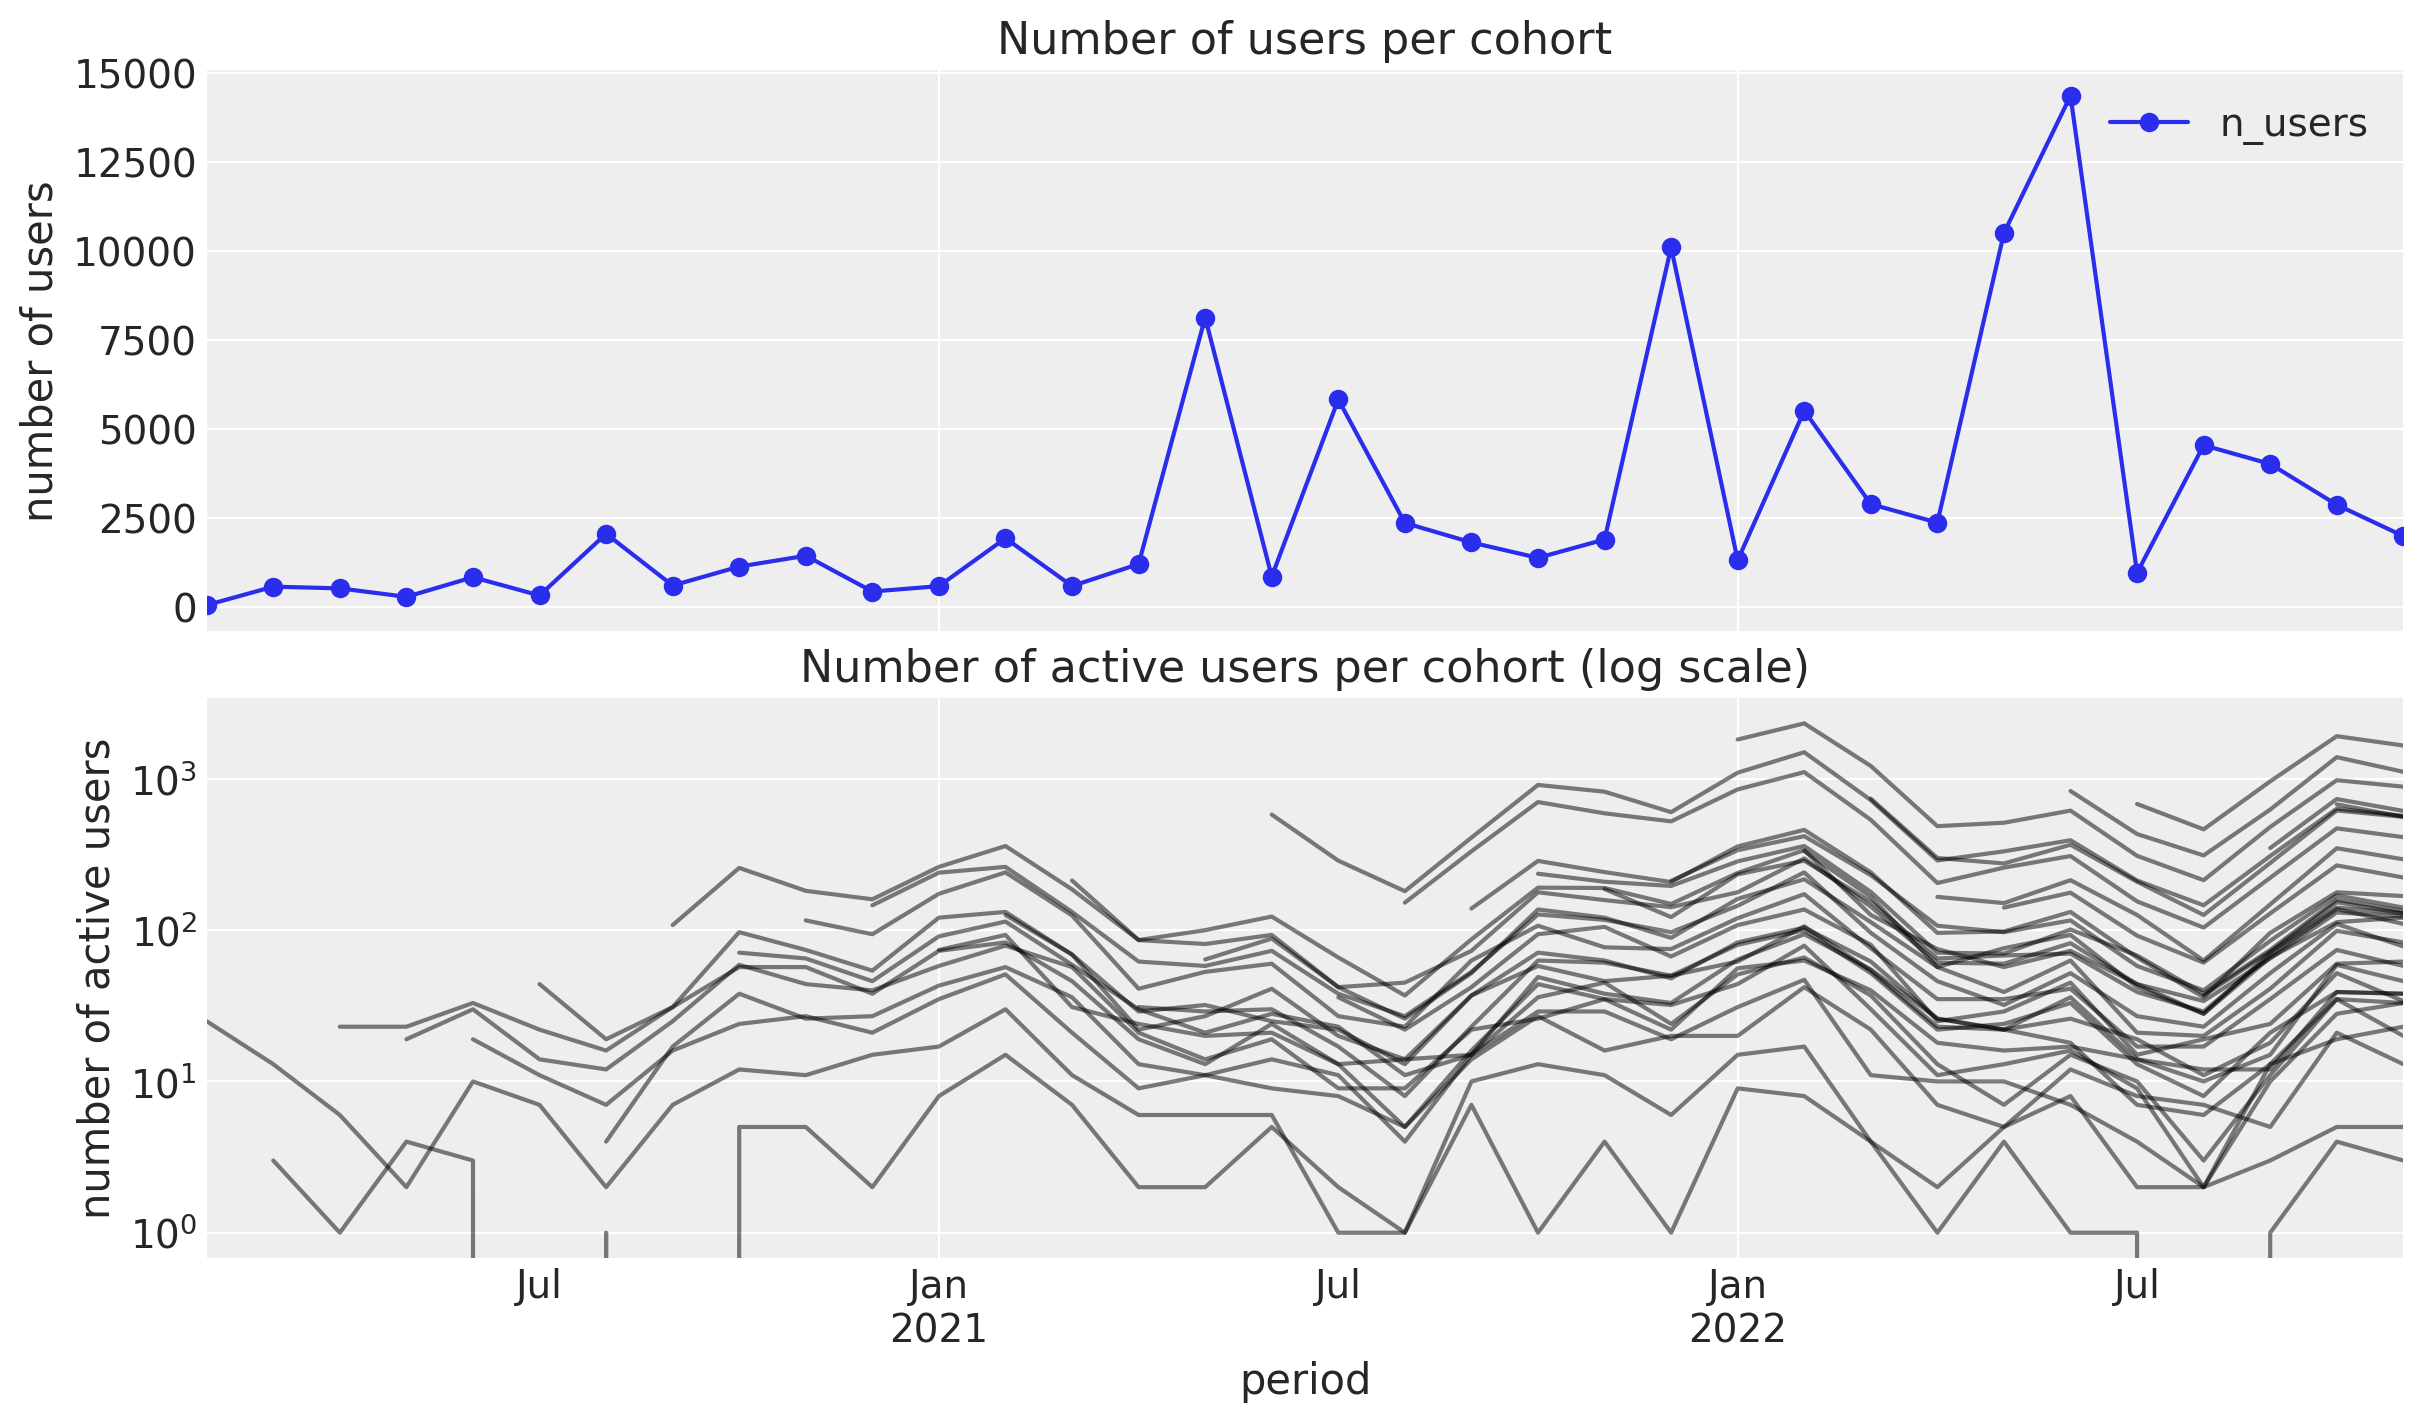

In [34]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=False, figsize=(12, 7), layout="constrained"
)
(
    train_data_df[["cohort", "n_users"]]
    .drop_duplicates()
    .set_index("cohort")
    .plot(color="C0", marker="o", ax=ax[0])
)
ax[0].set(title="Number of users per cohort", xlabel="cohort", ylabel="number of users")

for cohort in train_data_df["cohort"].unique()[:-1]:
    train_data_df.query("cohort == @cohort and cohort_age > 0").set_index("period")[
        "n_active_users"
    ].plot(color="black", alpha=0.5, ax=ax[1])

ax[1].set(
    title="Number of active users per cohort (log scale)",
    xlabel="period",
    ylabel="number of active users",
    yscale="log",
)


* Number of users:  We see a mild positive trend with some peaks which do not seem driven by seasonality.
* Number of returning users: We see a clear seasonality component with a peak in the winter months.

Now we plot the retention rates per cohort.

Text(0.5, 1.0, 'Retention by Cohort and Period')

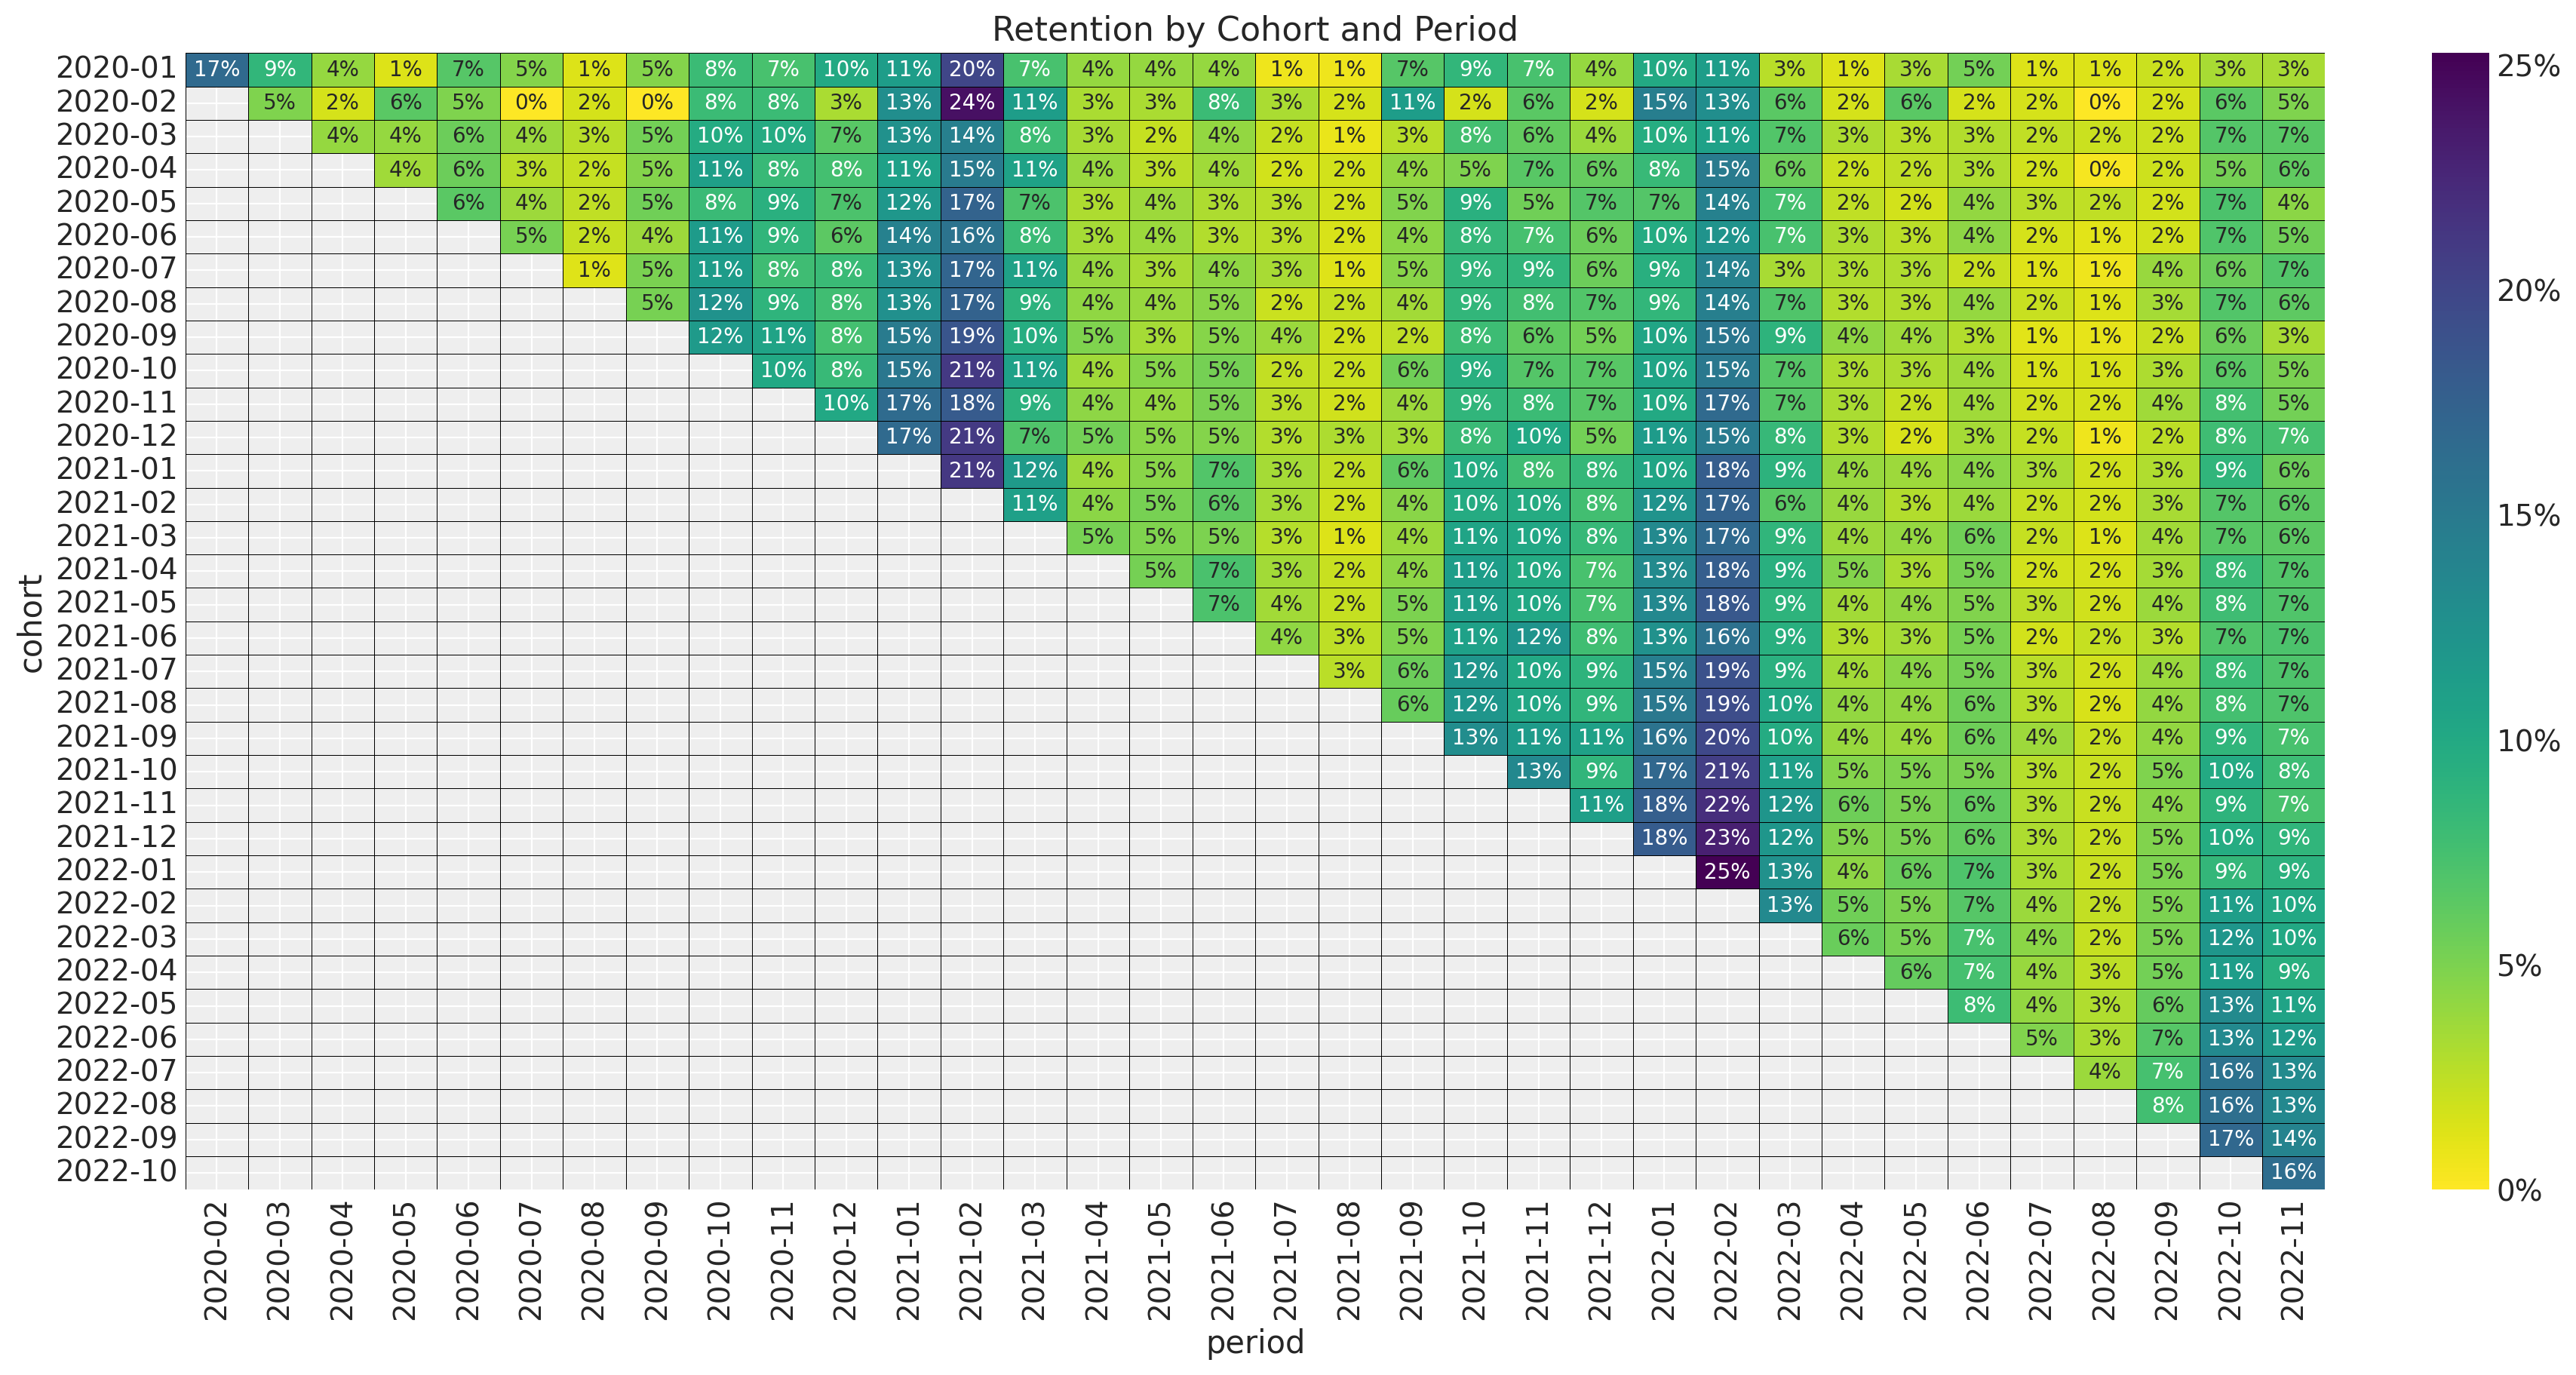

In [35]:
fig, ax = plt.subplots(figsize=(17, 9))

fmt = lambda y, _: f"{y :0.0%}"

(
    train_data_df.assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m"),
    )
    .query("cohort_age != 0")
    .filter(["cohort", "period", "retention"])
    .pivot(index="cohort", columns="period", values="retention")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(fmt)},
        ax=ax,
    )
)

ax.set_title("Retention by Cohort and Period")


[Text(0.5, 1.0, 'Retention by Cohort and Period')]

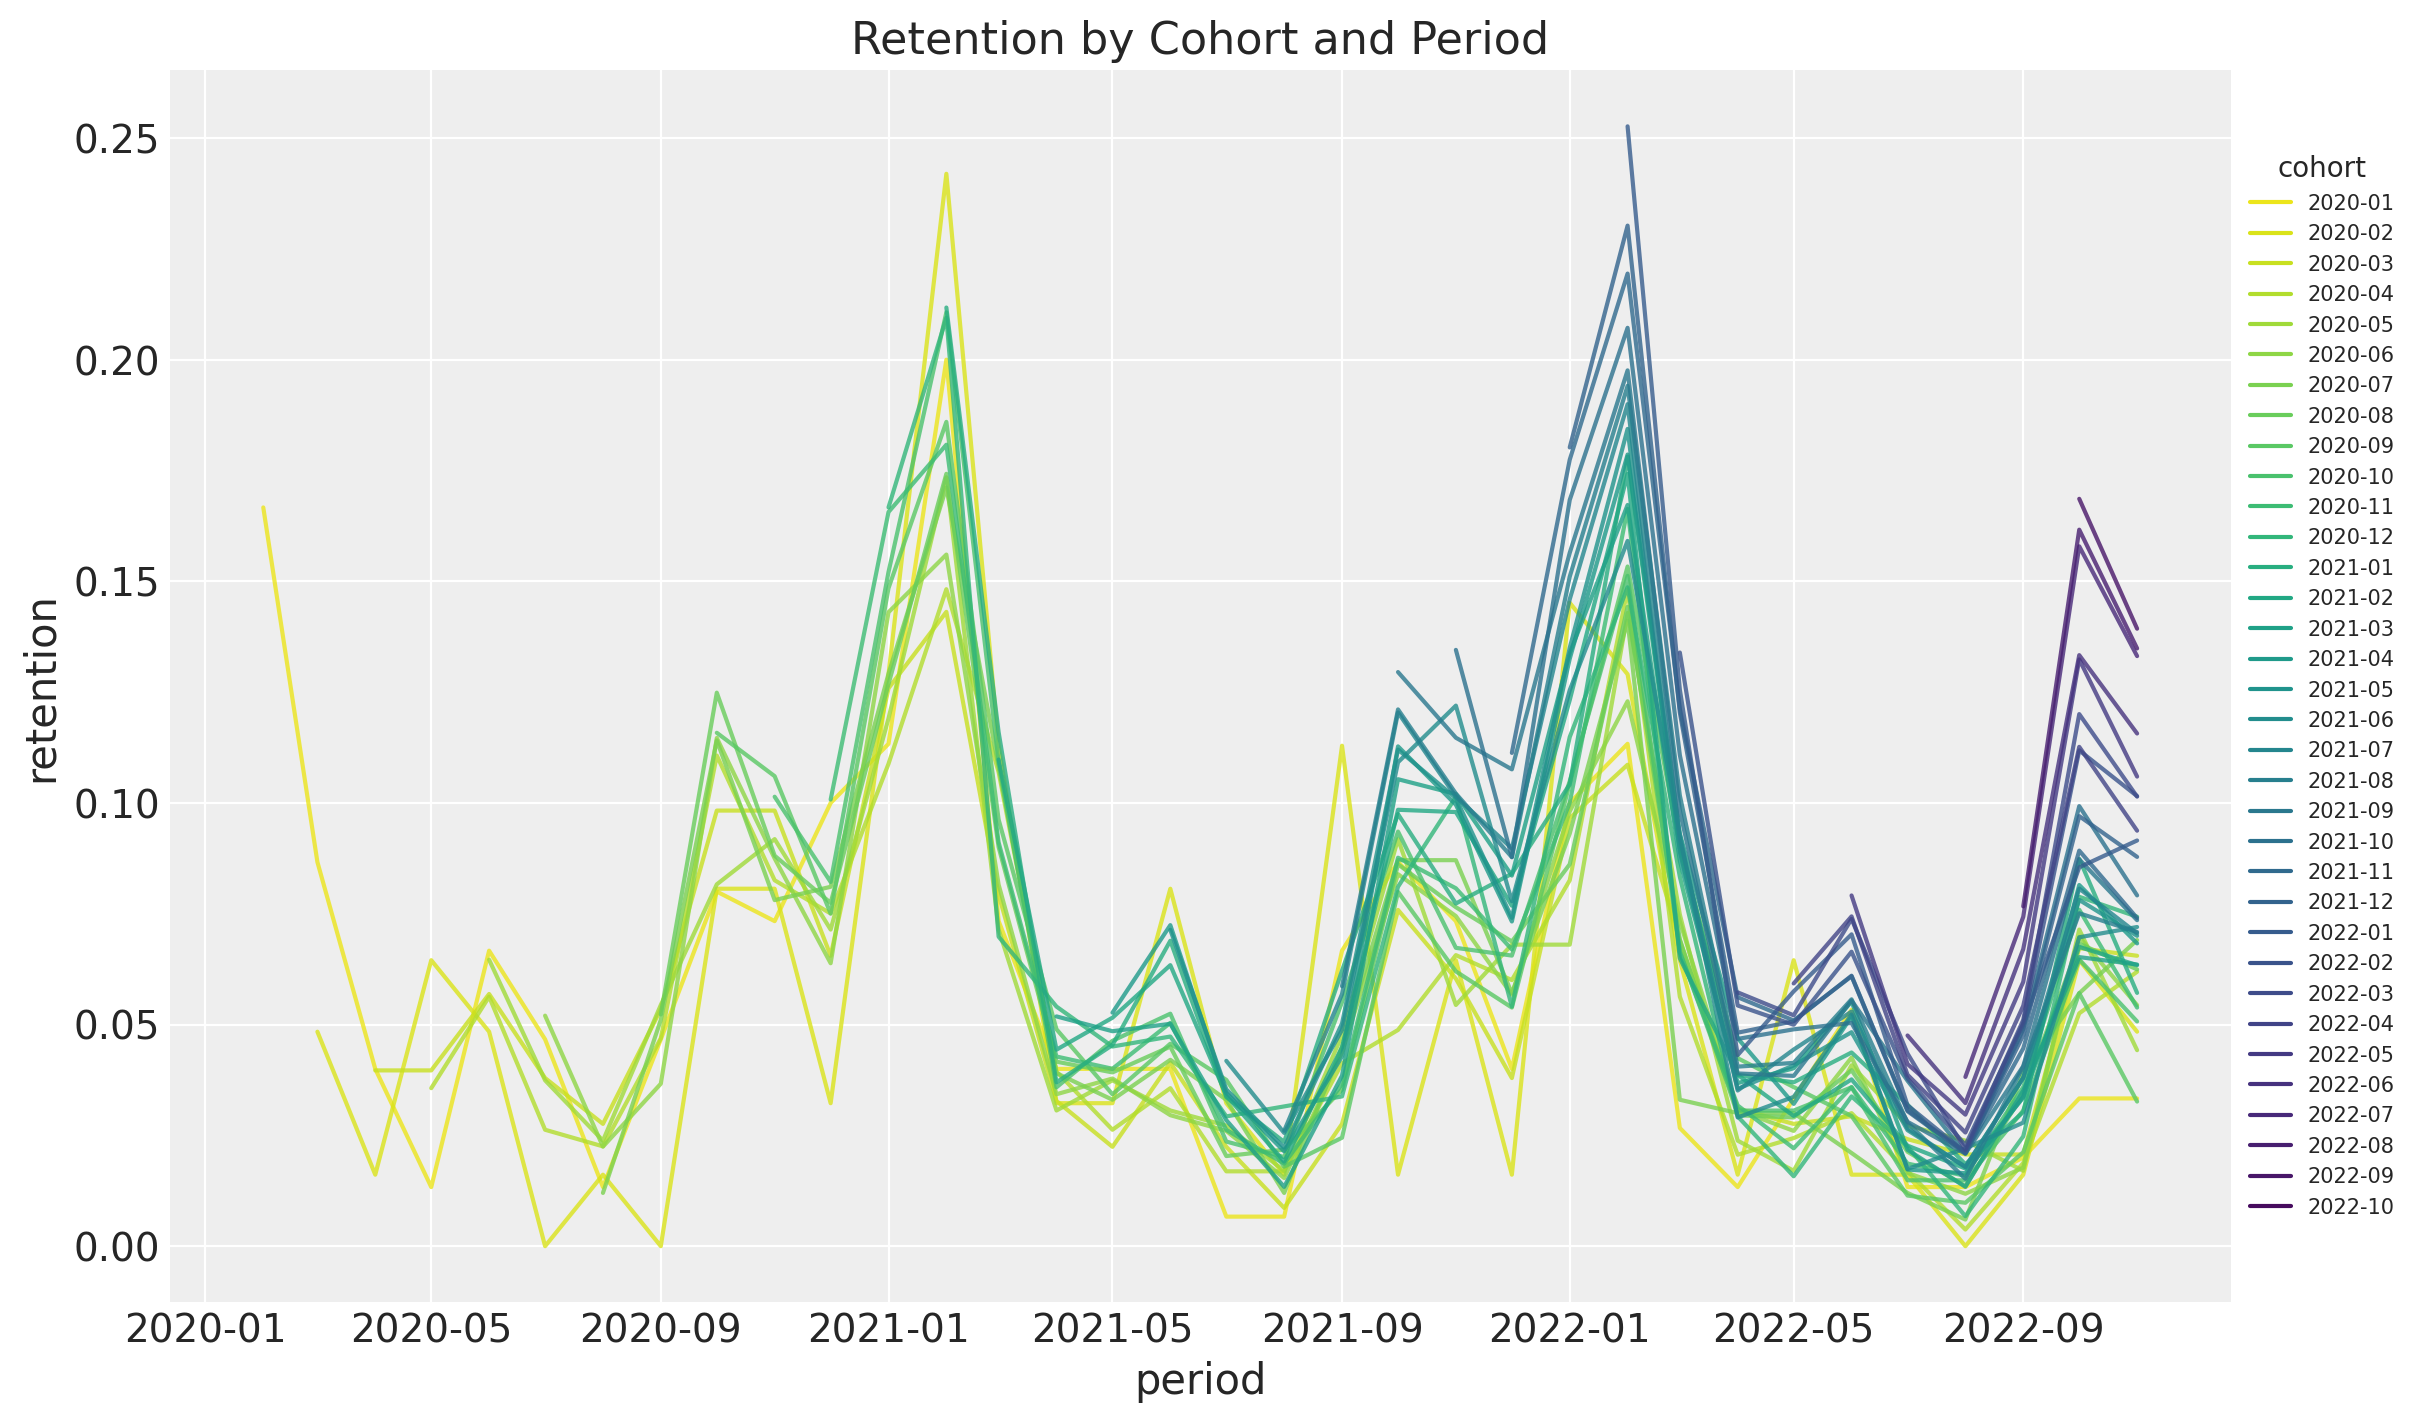

In [36]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    alpha=0.8,
    data=train_data_df.query("cohort_age > 0").assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m")
    ),
    ax=ax,
)
ax.legend(title="cohort", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set(title="Retention by Cohort and Period")


* It seems that for a given period, the retention rates of the new cohorts are higher than the retention rates of the older cohorts. This is a clear indication that the retention rate is a function of the absolute cohort age.
* We also see a clear seasonality component in the retention rates.
* For a given cohort, seasonality peaks are decreasing as a function of time (period).

Let's have a look at this last point in more detail. We plot the retention rates per month:


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


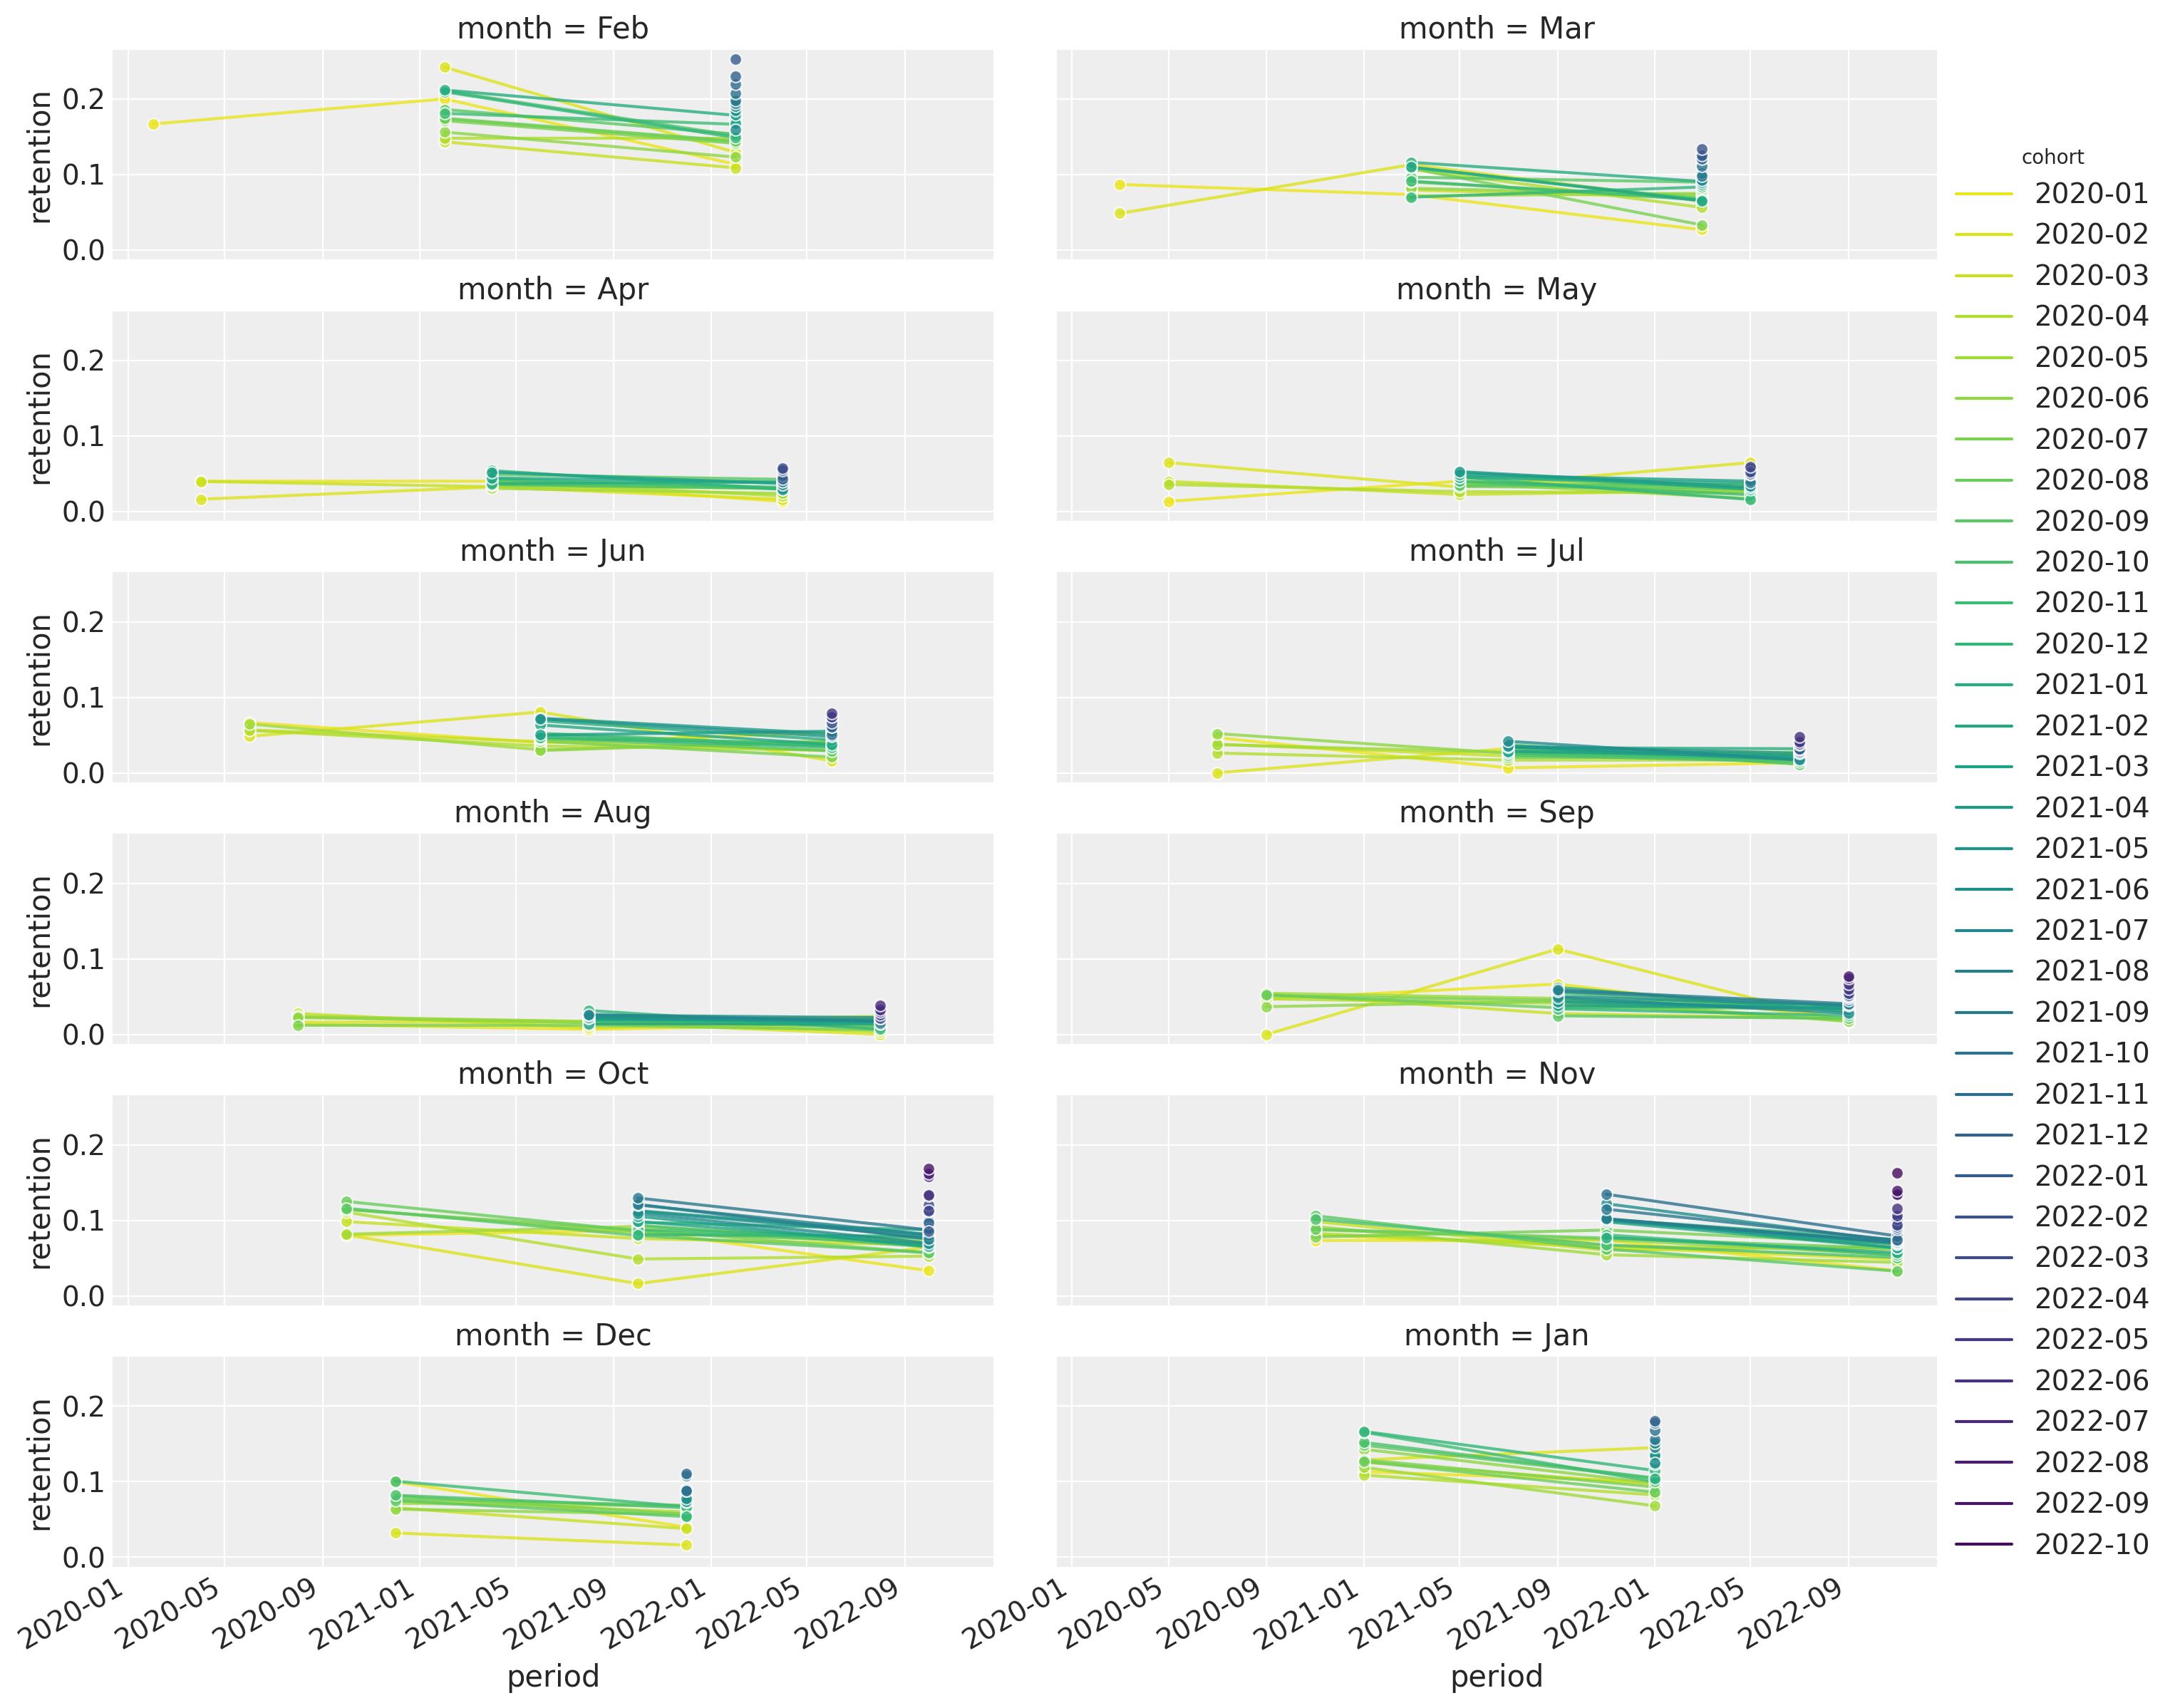

In [37]:
g = sns.relplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    col="month",
    col_wrap=2,
    kind="line",
    marker="o",
    alpha=0.8,
    data=train_data_df.query("cohort_age > 0").assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        month=lambda df: df["period"].dt.strftime("%b"),
    ),
    height=2.3,
    aspect=3,
    facet_kws={"sharex": True, "sharey": True},
)
g.fig.autofmt_xdate()

Finally, we plot the retention rates por each period (observation time) as a function of the cohort age (i.e. how long is the cohort):

[Text(0.5, 1.0, 'Retention by Cohort and Period')]

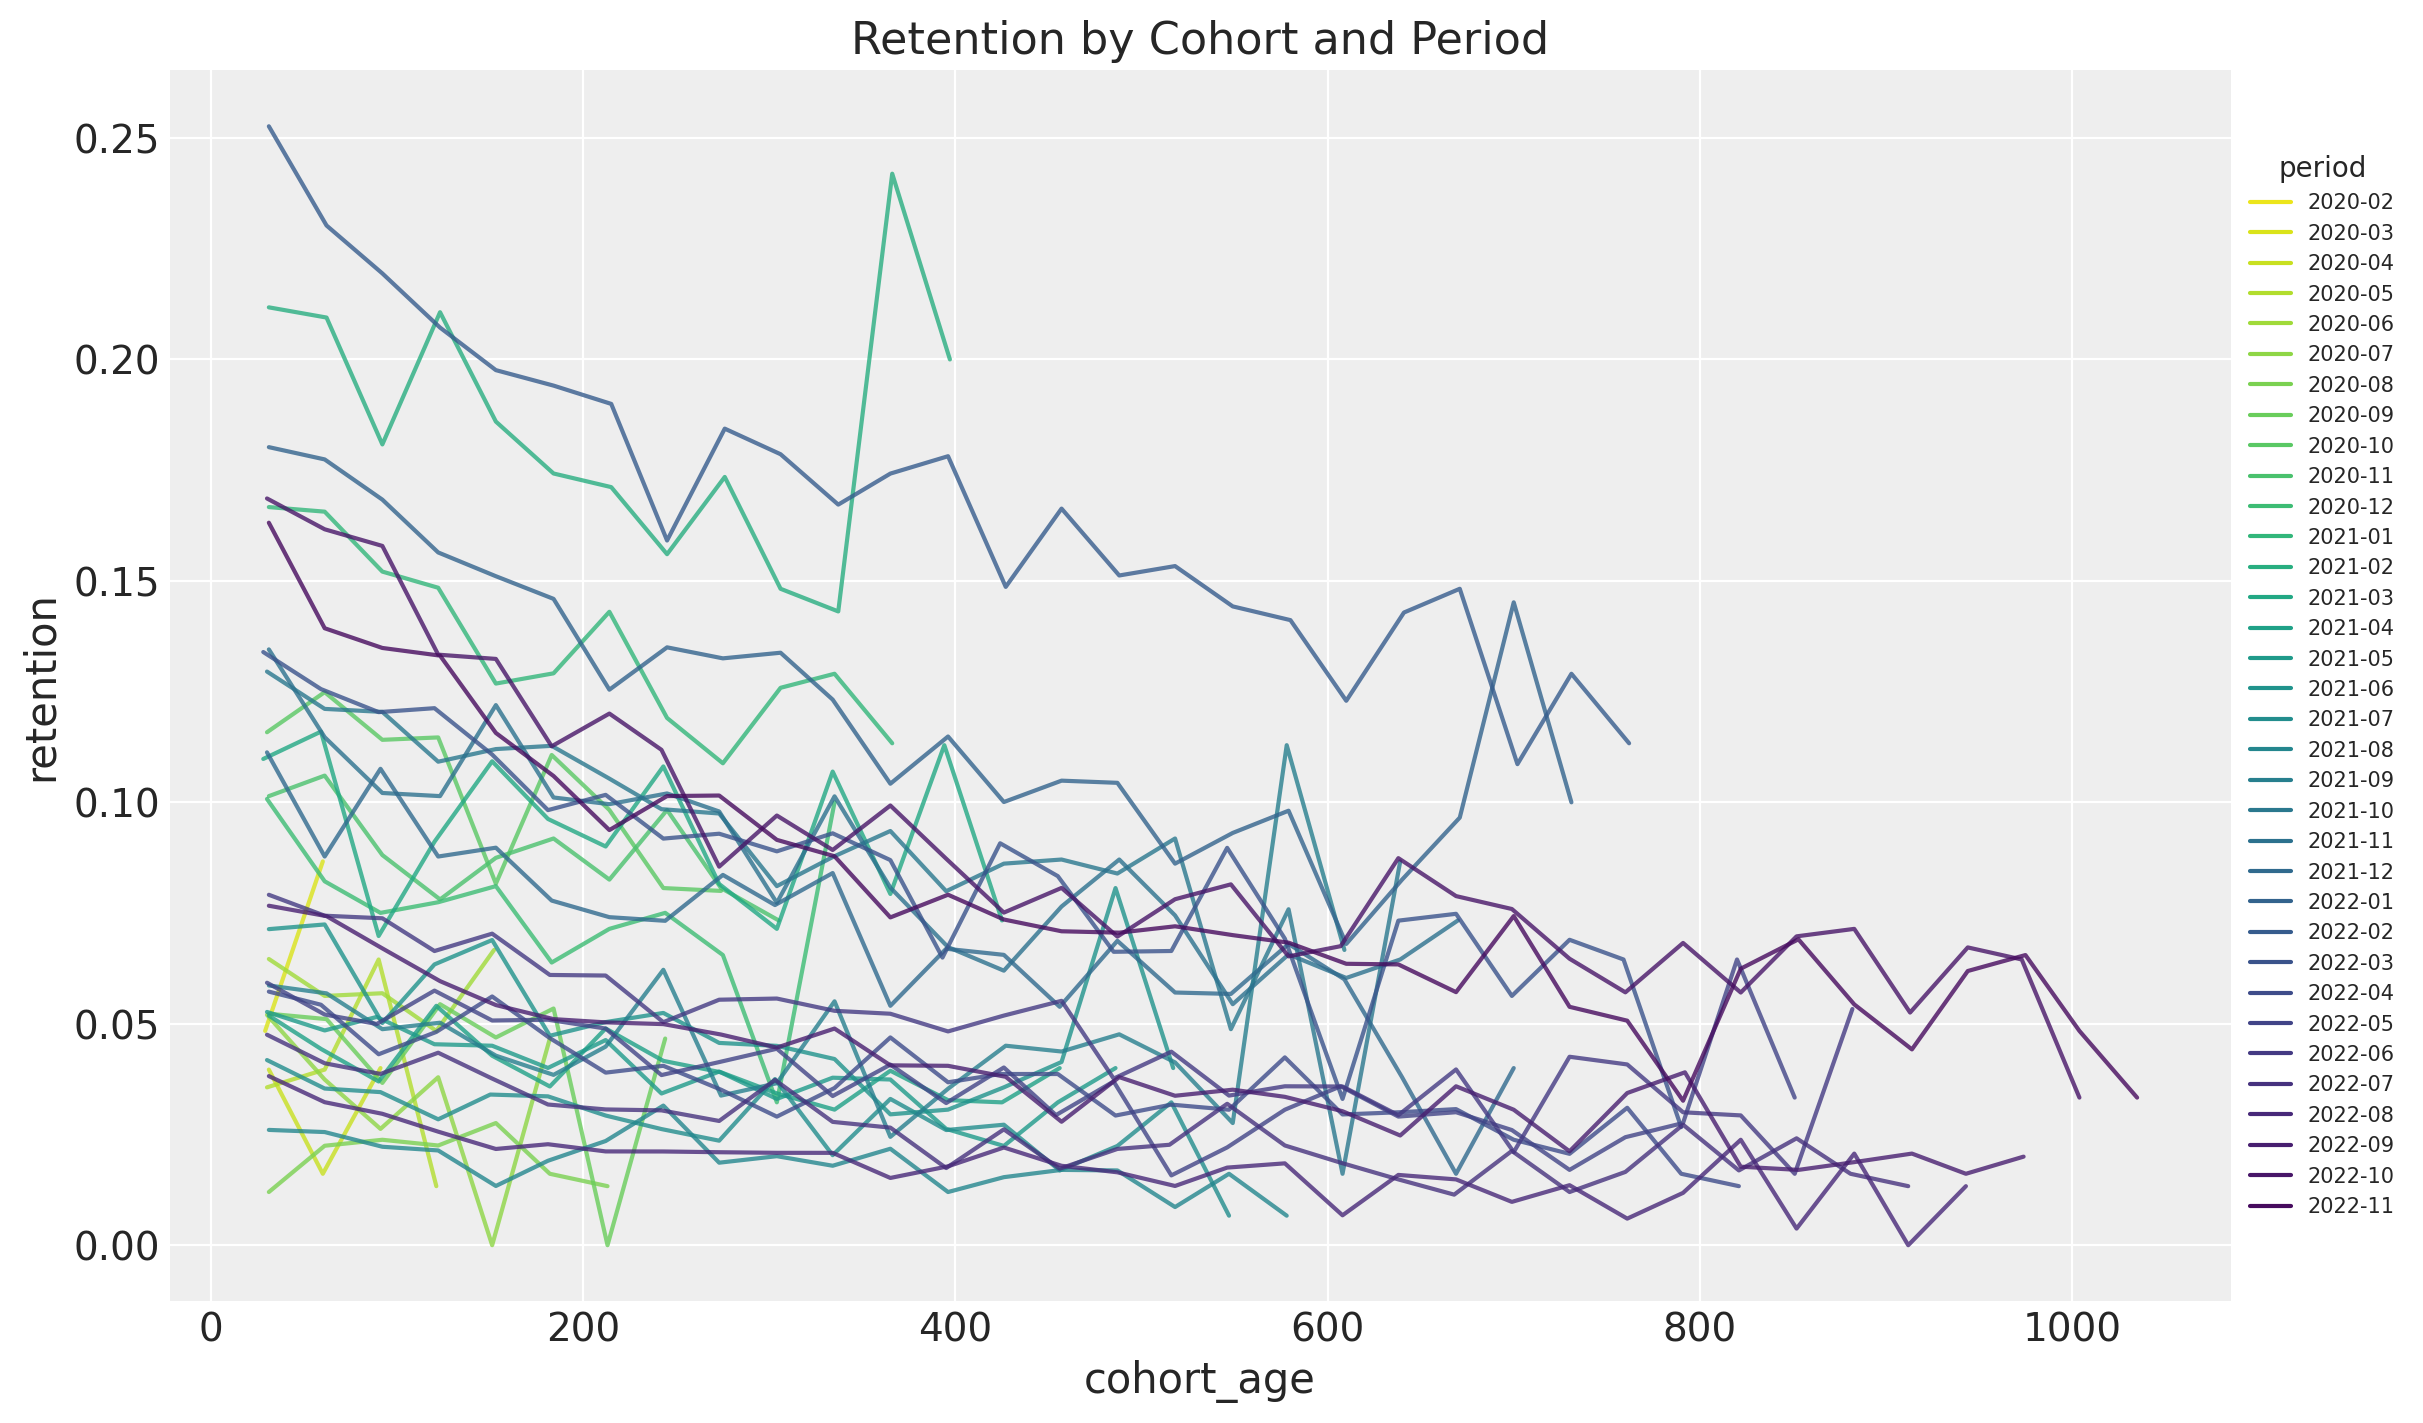

In [38]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(
    x="cohort_age",
    y="retention",
    hue="period",
    palette="viridis_r",
    alpha=0.8,
    data=train_data_df.query("cohort_age > 0").assign(
        period=lambda df: df["period"].dt.strftime("%Y-%m")
    ),
    ax=ax,
)
ax.legend(title="period", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set(title="Retention by Cohort and Period")


Most of them have a negative trend. This is just representing the vertical columns from the retention matrix above.

**One of the main takeaways from this EDA is that the retention rate is a function of (after controlling for seasonality) the absolute cohort age and the period, with a potential interaction effect.**

## Model

We now want to model the retention rates based in the EDA above. We use a generalized linear model with binomial likelihood and a logit link function. Concretely,


\begin{align*}
N_{\text{active}} \sim &\text{Binomial}(N_{\text{total}}, p) \\
\textrm{logit}(p) = (& \text{intercept} \\
    & + \beta_{\text{cohort age}} \text{cohort age} \\
    & + \beta_{\text{age}} \text{age} \\
    & + \beta_{\text{cohort age} \times \text{age}} \text{cohort age} \times \text{age} \\
    & + \beta_{\text{seasonality}} \text{seasonality} )
\end{align*}

We also choose normal priors which are not very informative.

**Remarks** 
- For the seasonality we use dummy monthly indicators. In addition, we use a [`ZeroSumNormal`](https://docs.pymc.io/en/v4.2.2/api/distributions/generated/pymc.ZeroSumNormal.html) distribution to model these terms as we re interested in the relative effect (note that we have an intercept in the model to account for the baseline).
- For the numerical variables (`cohort age` and `age`) we scale the data.

Before we jump into the data transformations and model fitting, let's have a look at the data structure:

In [39]:
train_data_df.head()

cohort  n_users     period   age  cohort_age  retention_true_mu  \
0 2020-01-01      150 2020-01-01  1430           0          -1.807373   
1 2020-01-01      150 2020-02-01  1430          31          -1.474736   
2 2020-01-01      150 2020-03-01  1430          60          -2.281286   
3 2020-01-01      150 2020-04-01  1430          91          -3.206610   
4 2020-01-01      150 2020-05-01  1430         121          -3.112983   

   retention_true  n_active_users  retention  
0        0.140956             150   1.000000  
1        0.186224              25   0.166667  
2        0.092685              13   0.086667  
3        0.038918               6   0.040000  
4        0.042575               2   0.013333

### Data Transformations

In [40]:
train_data_red_df = train_data_df.query("cohort_age > 0").reset_index(drop=True)
train_obs_idx = train_data_red_df.index.to_numpy()
train_n_users = train_data_red_df["n_users"].to_numpy()
train_n_active_users = train_data_red_df["n_active_users"].to_numpy()
train_retention = train_data_red_df["retention"].to_numpy()

# Continuous features
train_age = train_data_red_df["age"].to_numpy()
train_age_scaler = StandardScaler(with_mean=False)
train_age_scaled = train_age_scaler.fit_transform(train_age.reshape(-1, 1)).flatten()
train_cohort_age = train_data_red_df["cohort_age"].to_numpy()
train_cohort_age_scaler = StandardScaler(with_mean=False)
train_cohort_age_scaled = train_cohort_age_scaler.fit_transform(
    train_cohort_age.reshape(-1, 1)
).flatten()

# Categorical features
train_cohort = train_data_red_df["cohort"].to_numpy()
train_cohort_encoder = LabelEncoder()
train_cohort_idx = train_cohort_encoder.fit_transform(train_cohort).flatten()
train_period = train_data_red_df["period"].to_numpy()
train_period_encoder = LabelEncoder()
train_period_idx = train_period_encoder.fit_transform(train_period).flatten()
train_period_month = train_data_red_df["period"].dt.month.to_numpy()
train_period_month_encoder = LabelEncoder()
train_period_month_idx = train_period_month_encoder.fit_transform(
    train_period_month
).flatten()

coords: dict[str, npt.NDArray] = {
    "period_month": train_period_month_encoder.classes_,
}

**Remark:** Note that we know all features at prediction time!

### Model Specification

The following PyMC model implements the model specification above. We use [`pm.MutableData`](https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.MutableData.html) wrappers so that we can update the model with new data when generating predictions.

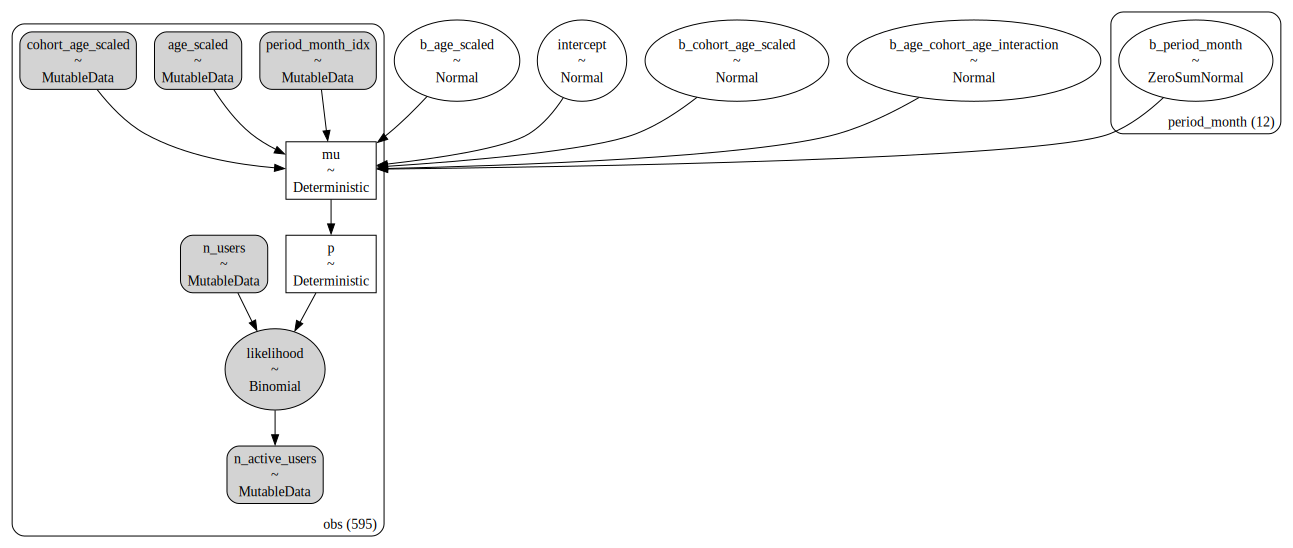

In [41]:
with pm.Model(coords=coords) as model:
    # --- Data ---
    model.add_coord(name="obs", values=train_obs_idx, mutable=True)
    age_scaled = pm.MutableData(name="age_scaled", value=train_age_scaled, dims="obs")
    cohort_age_scaled = pm.MutableData(
        name="cohort_age_scaled", value=train_cohort_age_scaled, dims="obs"
    )
    period_month_idx = pm.MutableData(
        name="period_month_idx", value=train_period_month_idx, dims="obs"
    )
    n_users = pm.MutableData(name="n_users", value=train_n_users, dims="obs")
    n_active_users = pm.MutableData(
        name="n_active_users", value=train_n_active_users, dims="obs"
    )

    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    b_age_scaled = pm.Normal(name="b_age_scaled", mu=0, sigma=1)
    b_cohort_age_scaled = pm.Normal(name="b_cohort_age_scaled", mu=0, sigma=1)
    b_period_month = pm.ZeroSumNormal(
        name="b_period_month", sigma=1, dims="period_month"
    )
    b_age_cohort_age_interaction = pm.Normal(
        name="b_age_cohort_age_interaction", mu=0, sigma=1
    )

    # --- Parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=intercept
        + b_age_scaled * age_scaled
        + b_cohort_age_scaled * cohort_age_scaled
        + b_age_cohort_age_interaction * age_scaled * cohort_age_scaled
        + b_period_month[period_month_idx],
        dims="obs",
    )

    p = pm.Deterministic(name="p", var=pm.math.invlogit(mu), dims="obs")

    # --- Likelihood ---
    pm.Binomial(
        name="likelihood",
        n=n_users,
        p=p,
        observed=n_active_users,
        dims="obs",
    )

pm.model_to_graphviz(model=model)

### Model Fitting

In [42]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.8, draws=2_000, chains=5, random_seed=rng
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

Compiling...
Compilation time =  0:00:07.259810
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:28.188209
Transforming variables...
Transformation time =  0:00:01.927697


Sampling: [likelihood]


### Model Diagnostics

The model samples nicely and diagnostics look good:

In [43]:
az.summary(data=idata, var_names=["~mu", "~p"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
intercept                    -1.857  0.023  -1.900   -1.813        0.0   
b_age_scaled                 -0.141  0.007  -0.154   -0.129        0.0   
b_cohort_age_scaled          -0.567  0.027  -0.618   -0.518        0.0   
b_age_cohort_age_interaction  0.075  0.006   0.063    0.086        0.0   
b_period_month[1]             0.807  0.012   0.784    0.830        0.0   
b_period_month[2]             1.178  0.011   1.157    1.198        0.0   
b_period_month[3]             0.406  0.013   0.382    0.429        0.0   
b_period_month[4]            -0.507  0.018  -0.542   -0.474        0.0   
b_period_month[5]            -0.461  0.018  -0.493   -0.427        0.0   
b_period_month[6]            -0.182  0.014  -0.207   -0.155        0.0   
b_period_month[7]            -0.808  0.017  -0.838   -0.776        0.0   
b_period_month[8]            -1.182  0.019  -1.218   -1.149        0.0   
b_period_month[9]            -0.351  0.013  -0.376   -0.327        0.0   
b_period_month[10]            0.511  0.009   0.493    0.529        0.0   
b_period_month[11]            0.394  0.010   0.376    0.414        0.0   
b_period_month[12]            0.195  0.017   0.163    0.226        0.0   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
intercept                         0.0    5268.0    6211.0    1.0  
b_age_scaled                      0.0    6027.0    6953.0    1.0  
b_cohort_age_scaled               0.0    6122.0    6475.0    1.0  
b_age_cohort_age_interaction      0.0    5737.0    6721.0    1.0  
b_period_month[1]                 0.0   15128.0    6997.0    1.0  
b_period_month[2]                 0.0   14230.0    6658.0    1.0  
b_period_month[3]                 0.0   14577.0    7000.0    1.0  
b_period_month[4]                 0.0   14347.0    6845.0    1.0  
b_period_month[5]                 0.0   13878.0    7201.0    1.0  
b_period_month[6]                 0.0   12910.0    7074.0    1.0  
b_period_month[7]                 0.0   14924.0    7176.0    1.0  
b_period_month[8]                 0.0   14697.0    7902.0    1.0  
b_period_month[9]                 0.0   13270.0    7077.0    1.0  
b_period_month[10]                0.0   14560.0    8011.0    1.0  
b_period_month[11]                0.0   13493.0    7446.0    1.0  
b_period_month[12]                0.0    9984.0    7571.0    1.0

Text(0.5, 0.98, 'Model Trace')

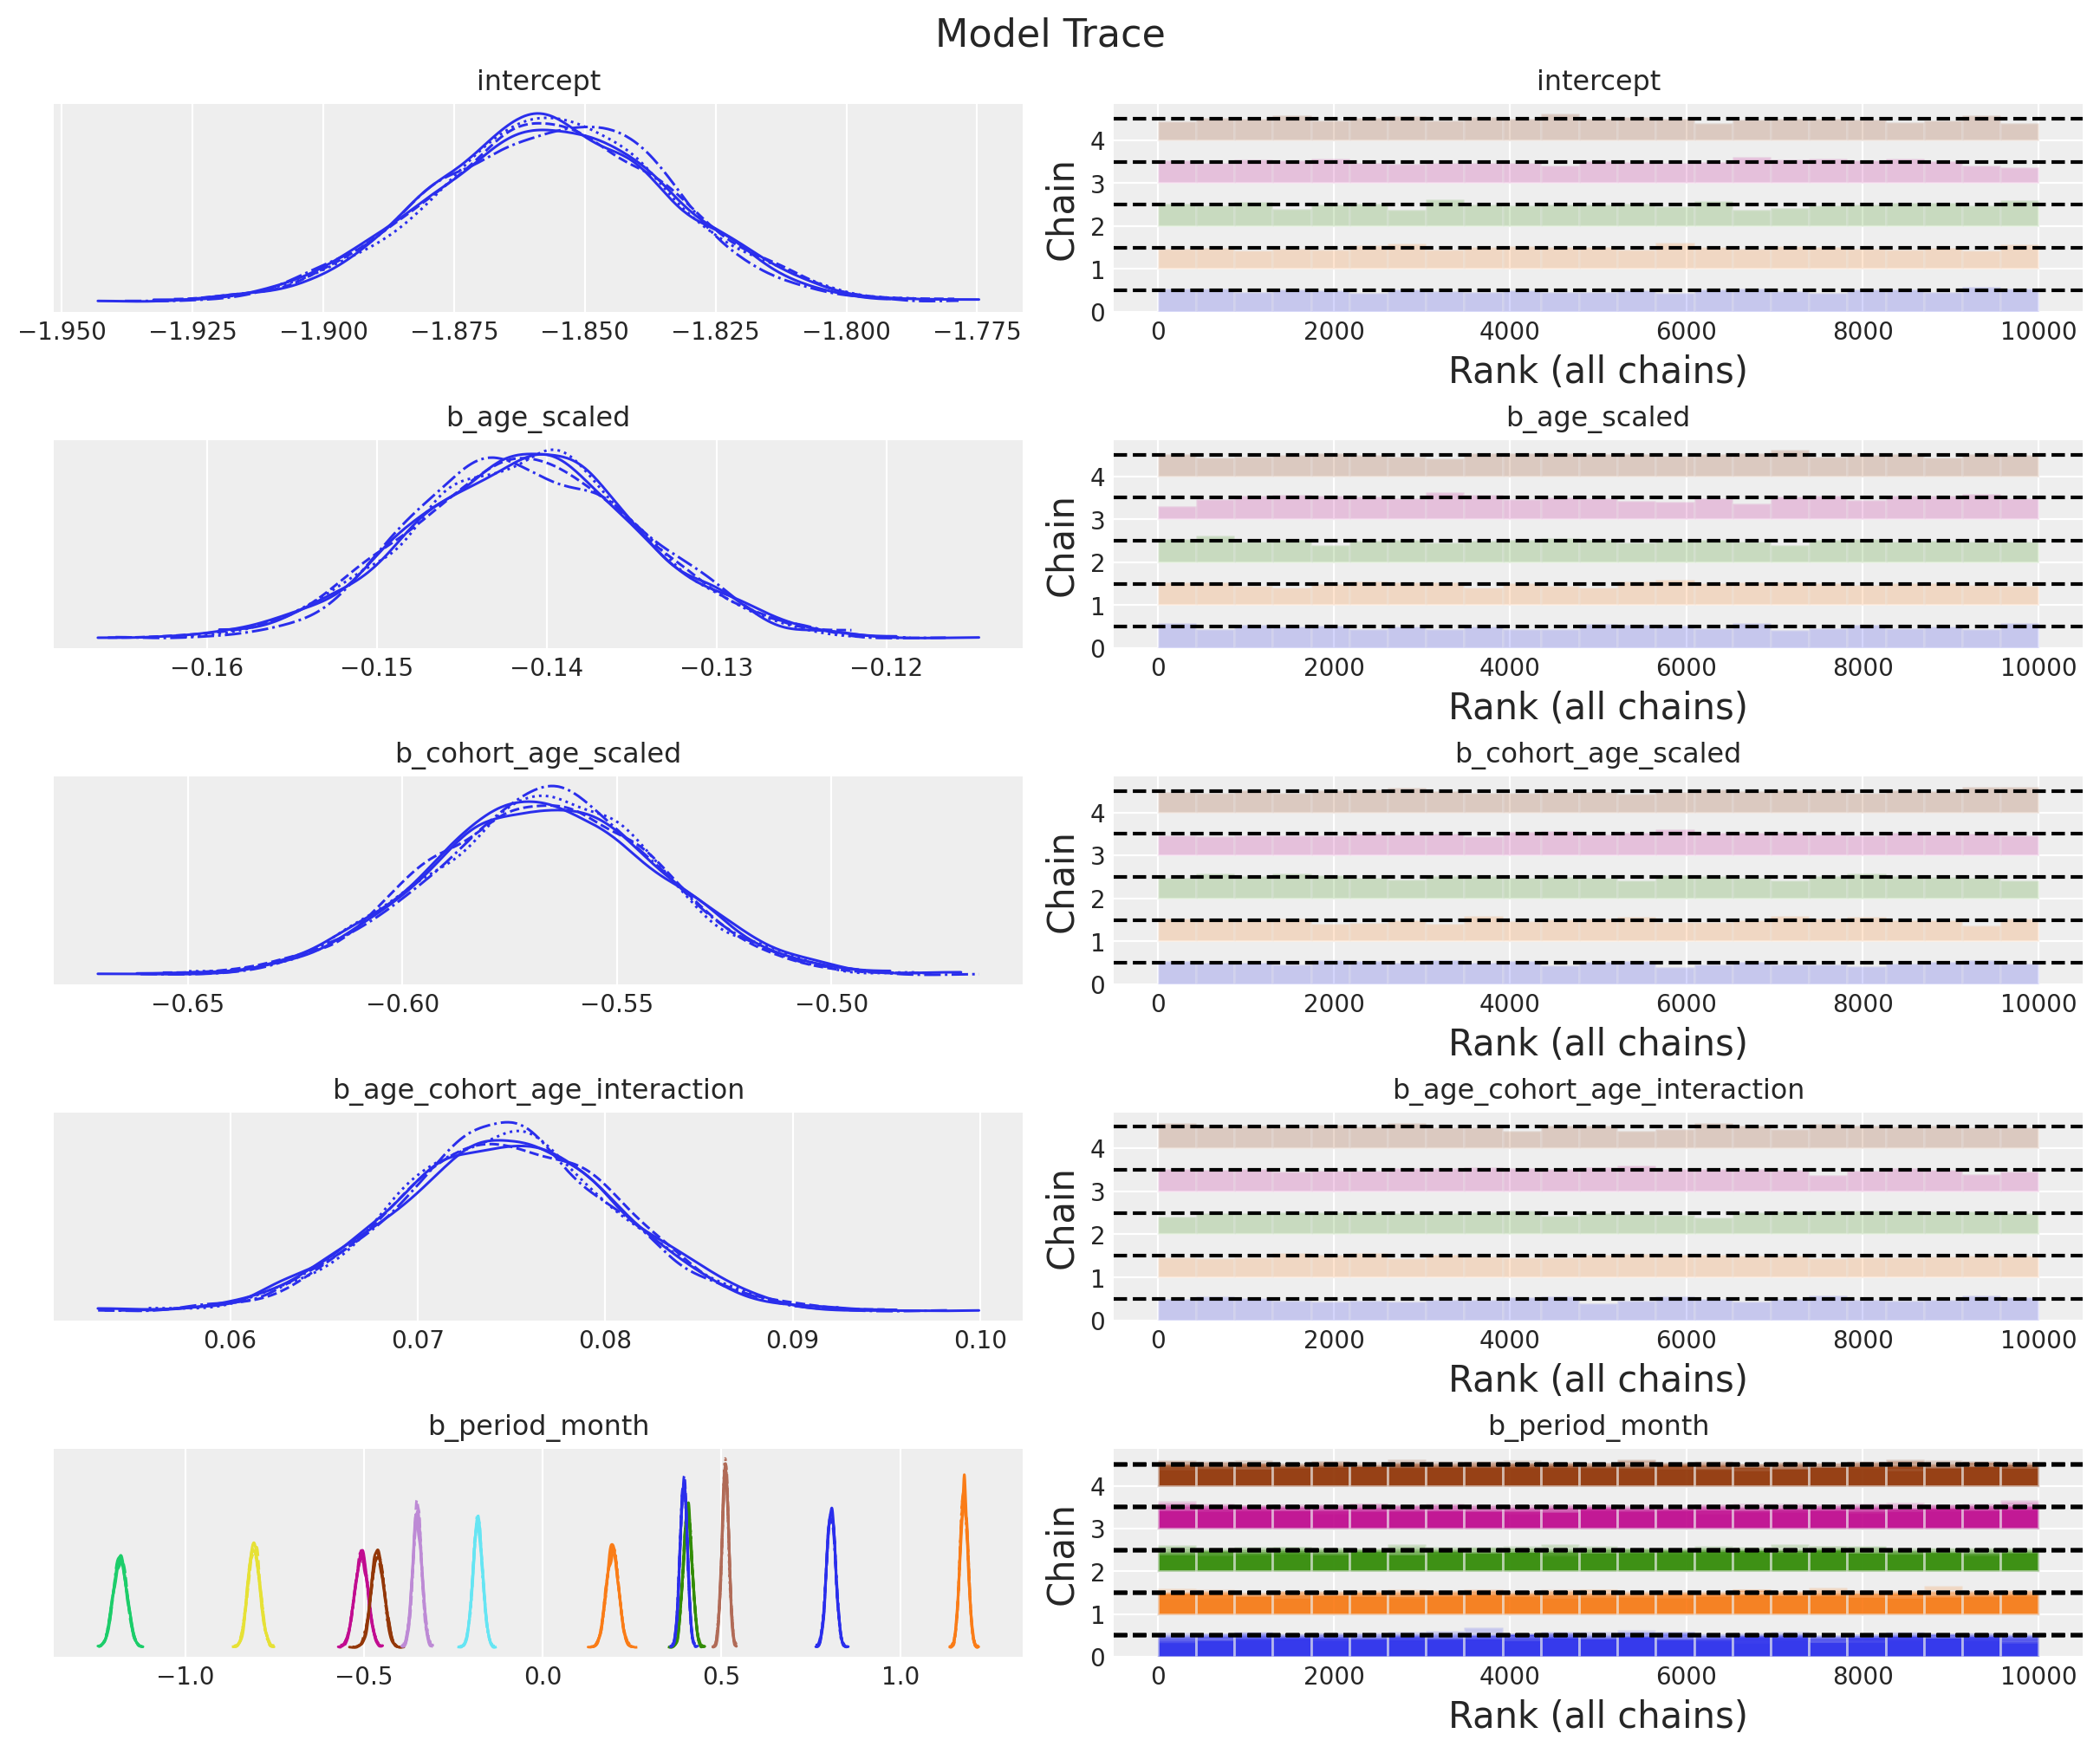

In [44]:
_ = az.plot_trace(
    data=idata,
    var_names=["~mu", "~p"],
    kind="rank_bars",
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16)

[Text(0.5, 1.0, 'Model Posterior Predictive'), Text(0.5, 0, 'Retention')]

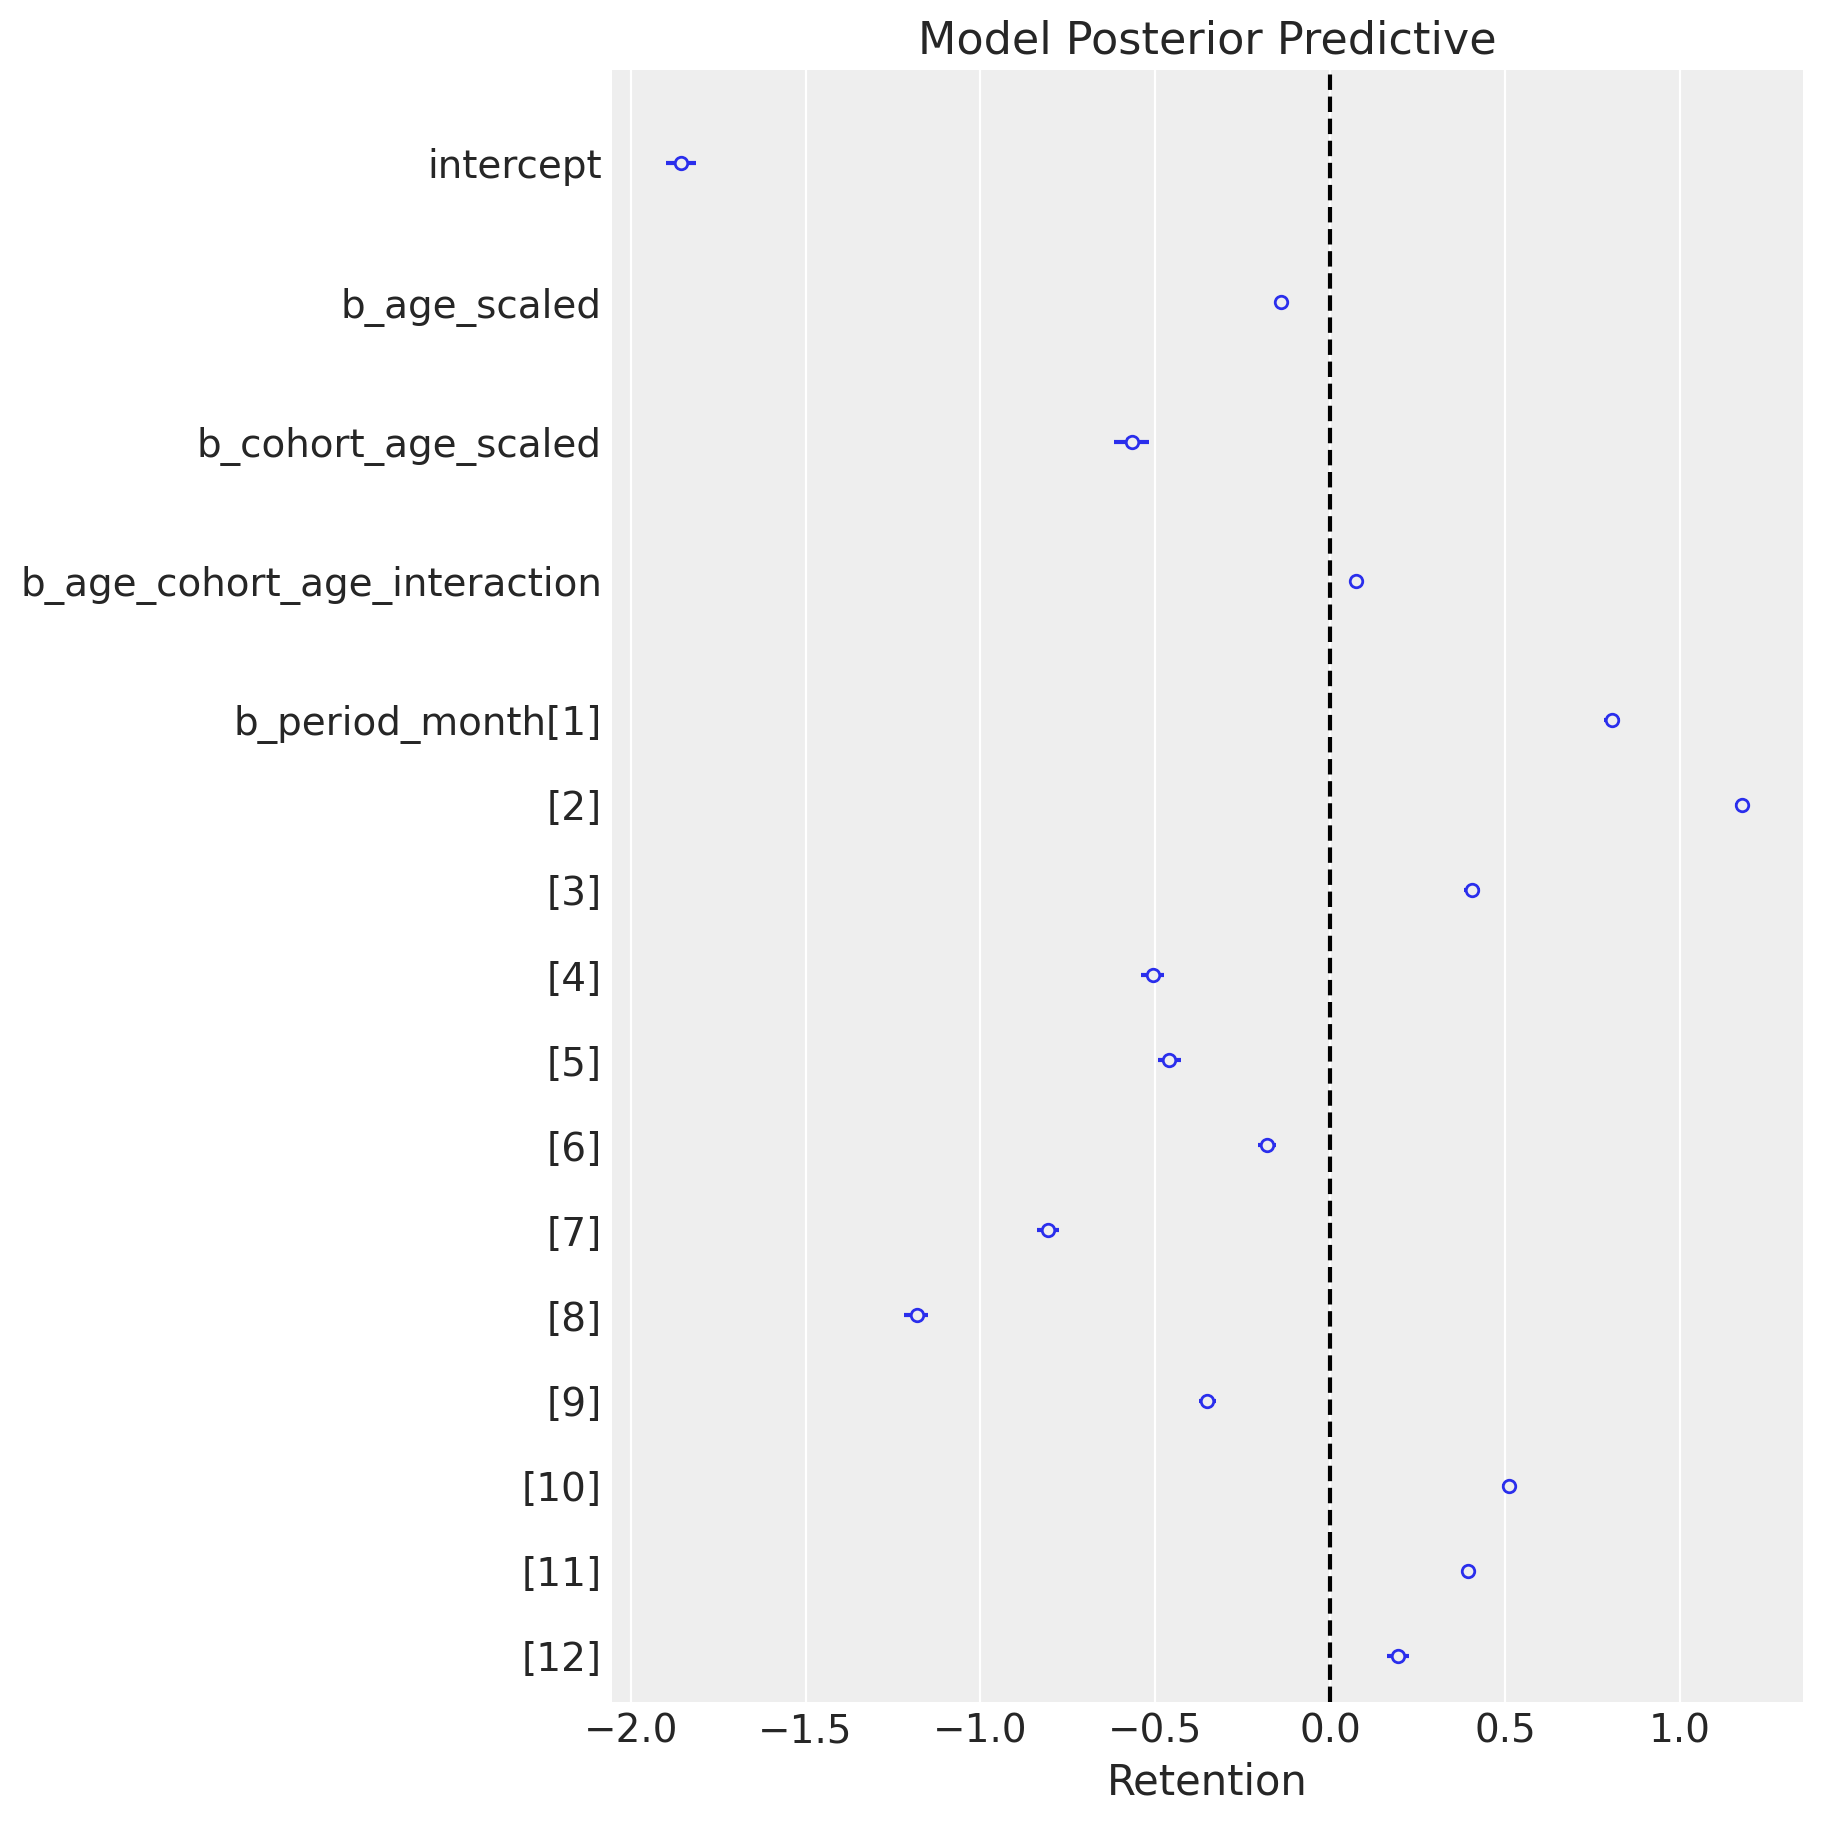

In [45]:
ax, *_ = az.plot_forest(
    data=idata, var_names=["~mu", "~p"], combined=True, figsize=(9, 9)
)
ax.axvline(x=0, color="black", linestyle="--")
ax.set(title="Model Posterior Predictive", xlabel="Retention")


It is nice to see how the seasonality coefficients resemble seasonality patterns from the EDA.

We can now look into the posterior predictive check:

[Text(0.5, 1.0, 'Posterior Predictive Check'),
 None,
 Text(0.5, 0, 'likelihood (n_active_users) - log scale')]

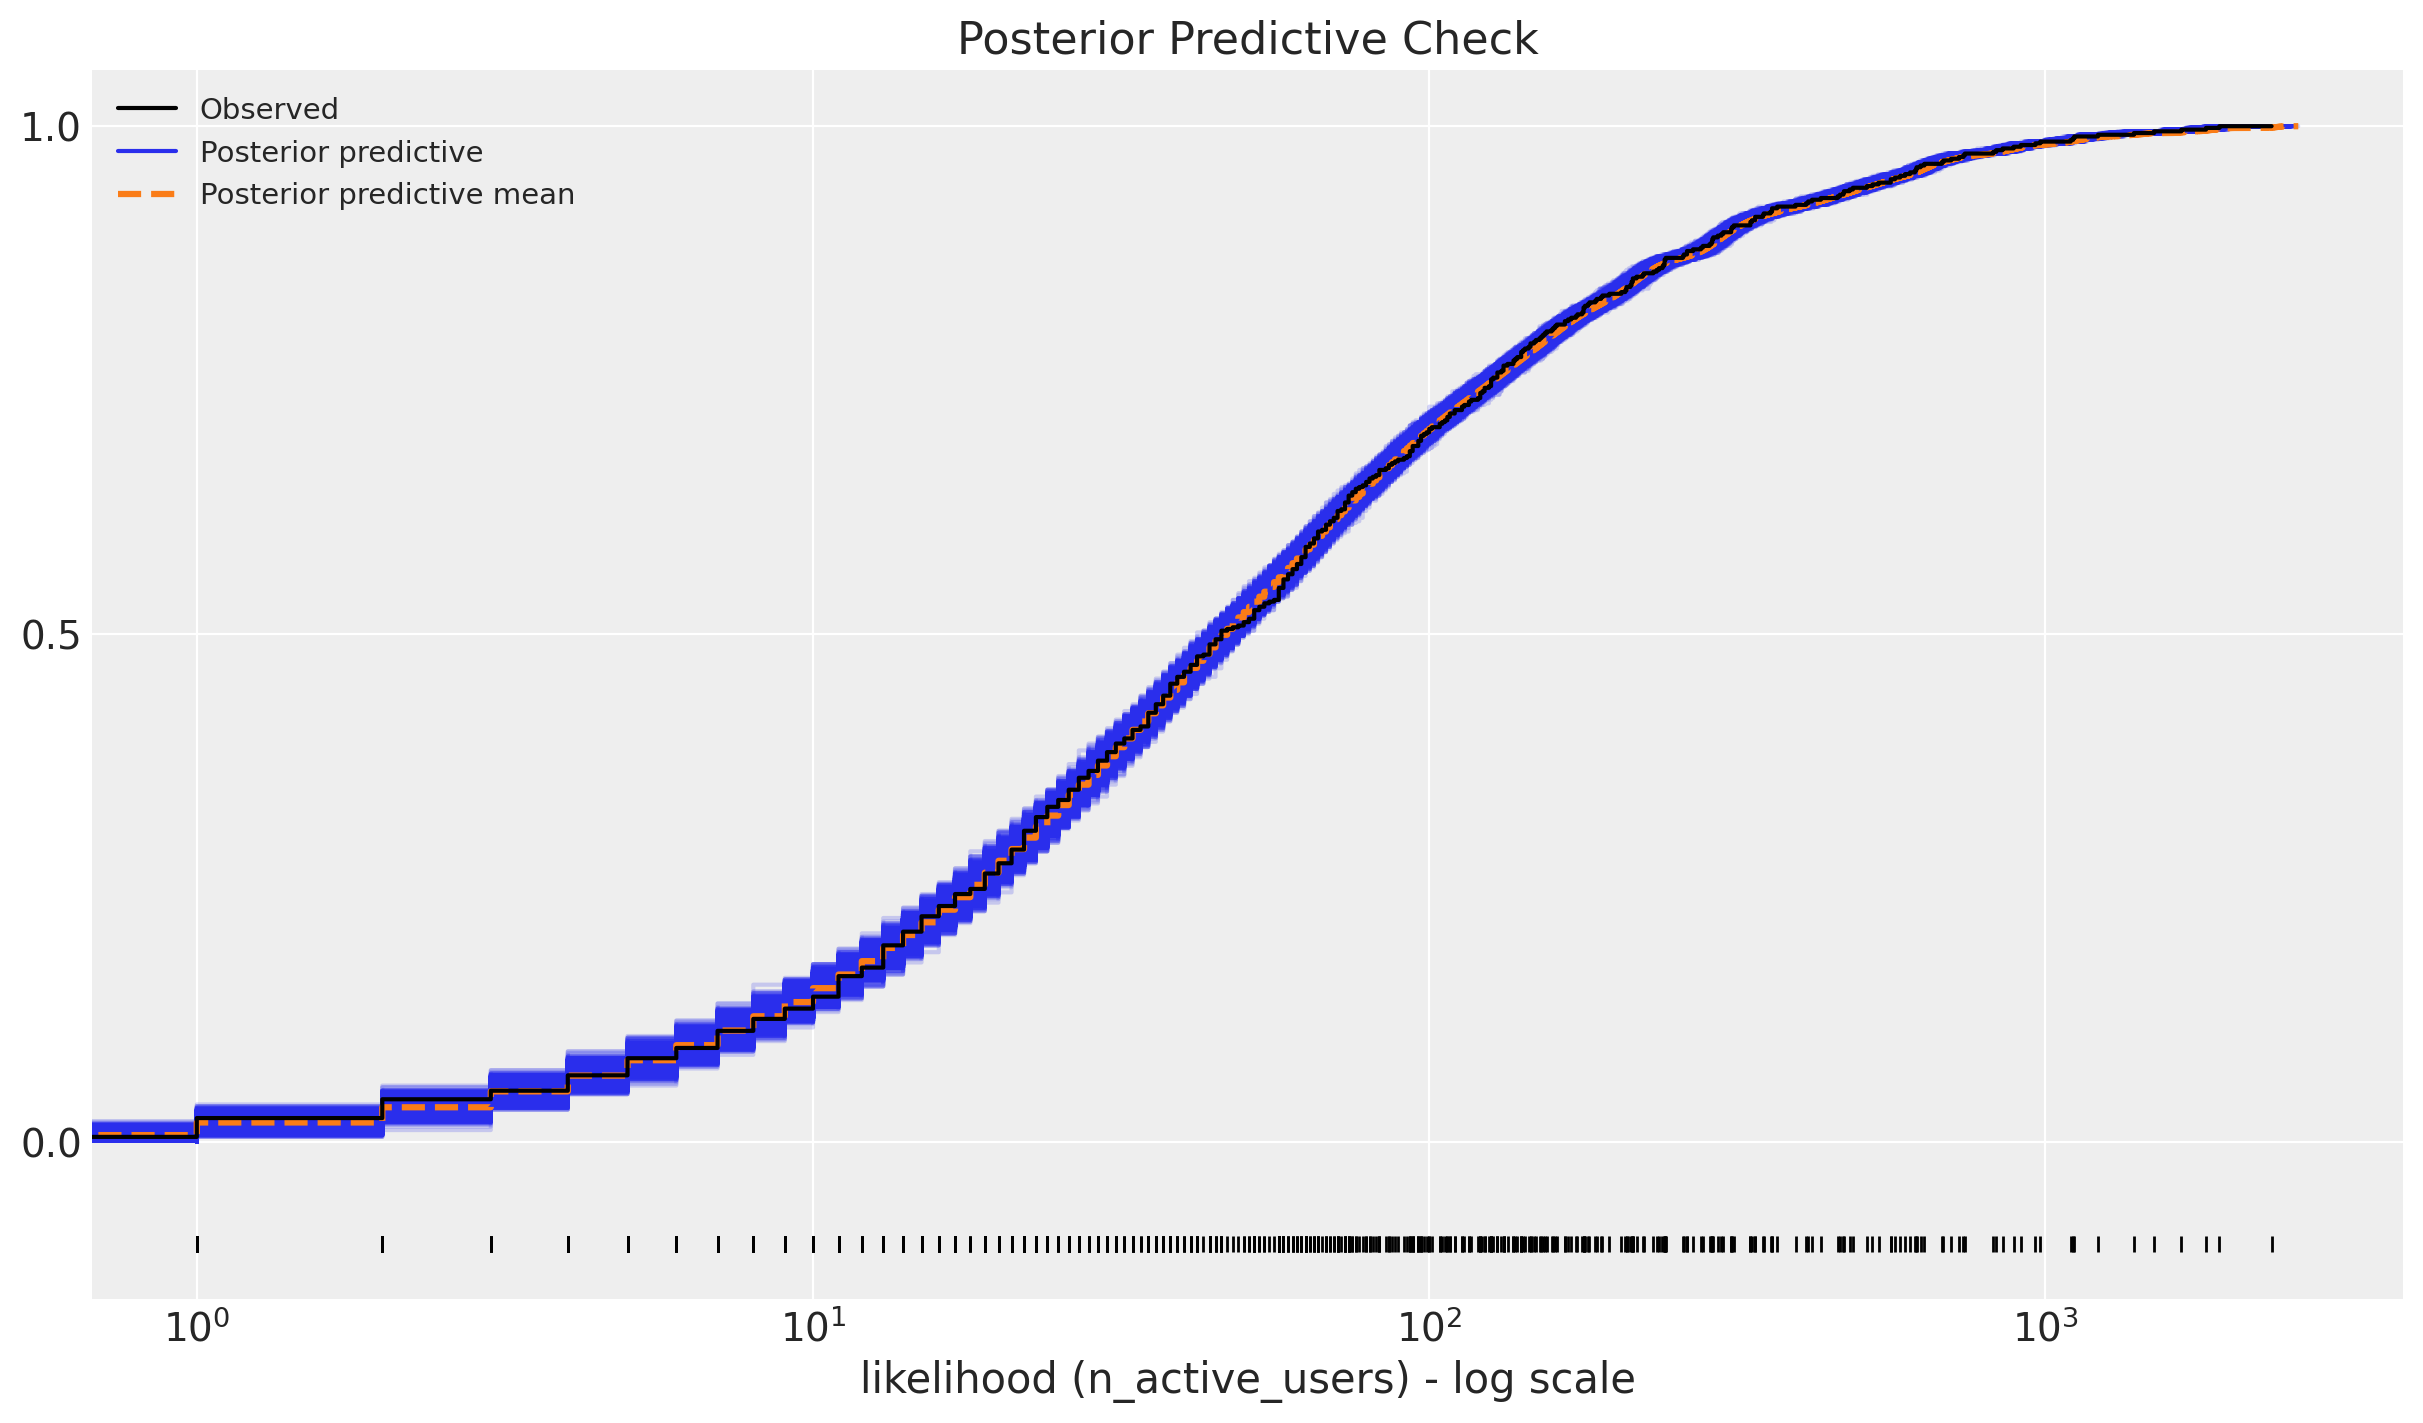

In [46]:
ax = az.plot_ppc(data=posterior_predictive, kind="cumulative", observed_rug=True)
ax.set(
    title="Posterior Predictive Check",
    xscale="log",
    xlabel="likelihood (n_active_users) - log scale",
)


### Retention Rate In-Sample Predictions

Now we can use the model to predict the retention rates for the training data. We plot the observed retention rates and the predicted (posterior mean) retention rates.

[Text(0.5, 1.0, 'Posterior Predictive - Retention Mean')]

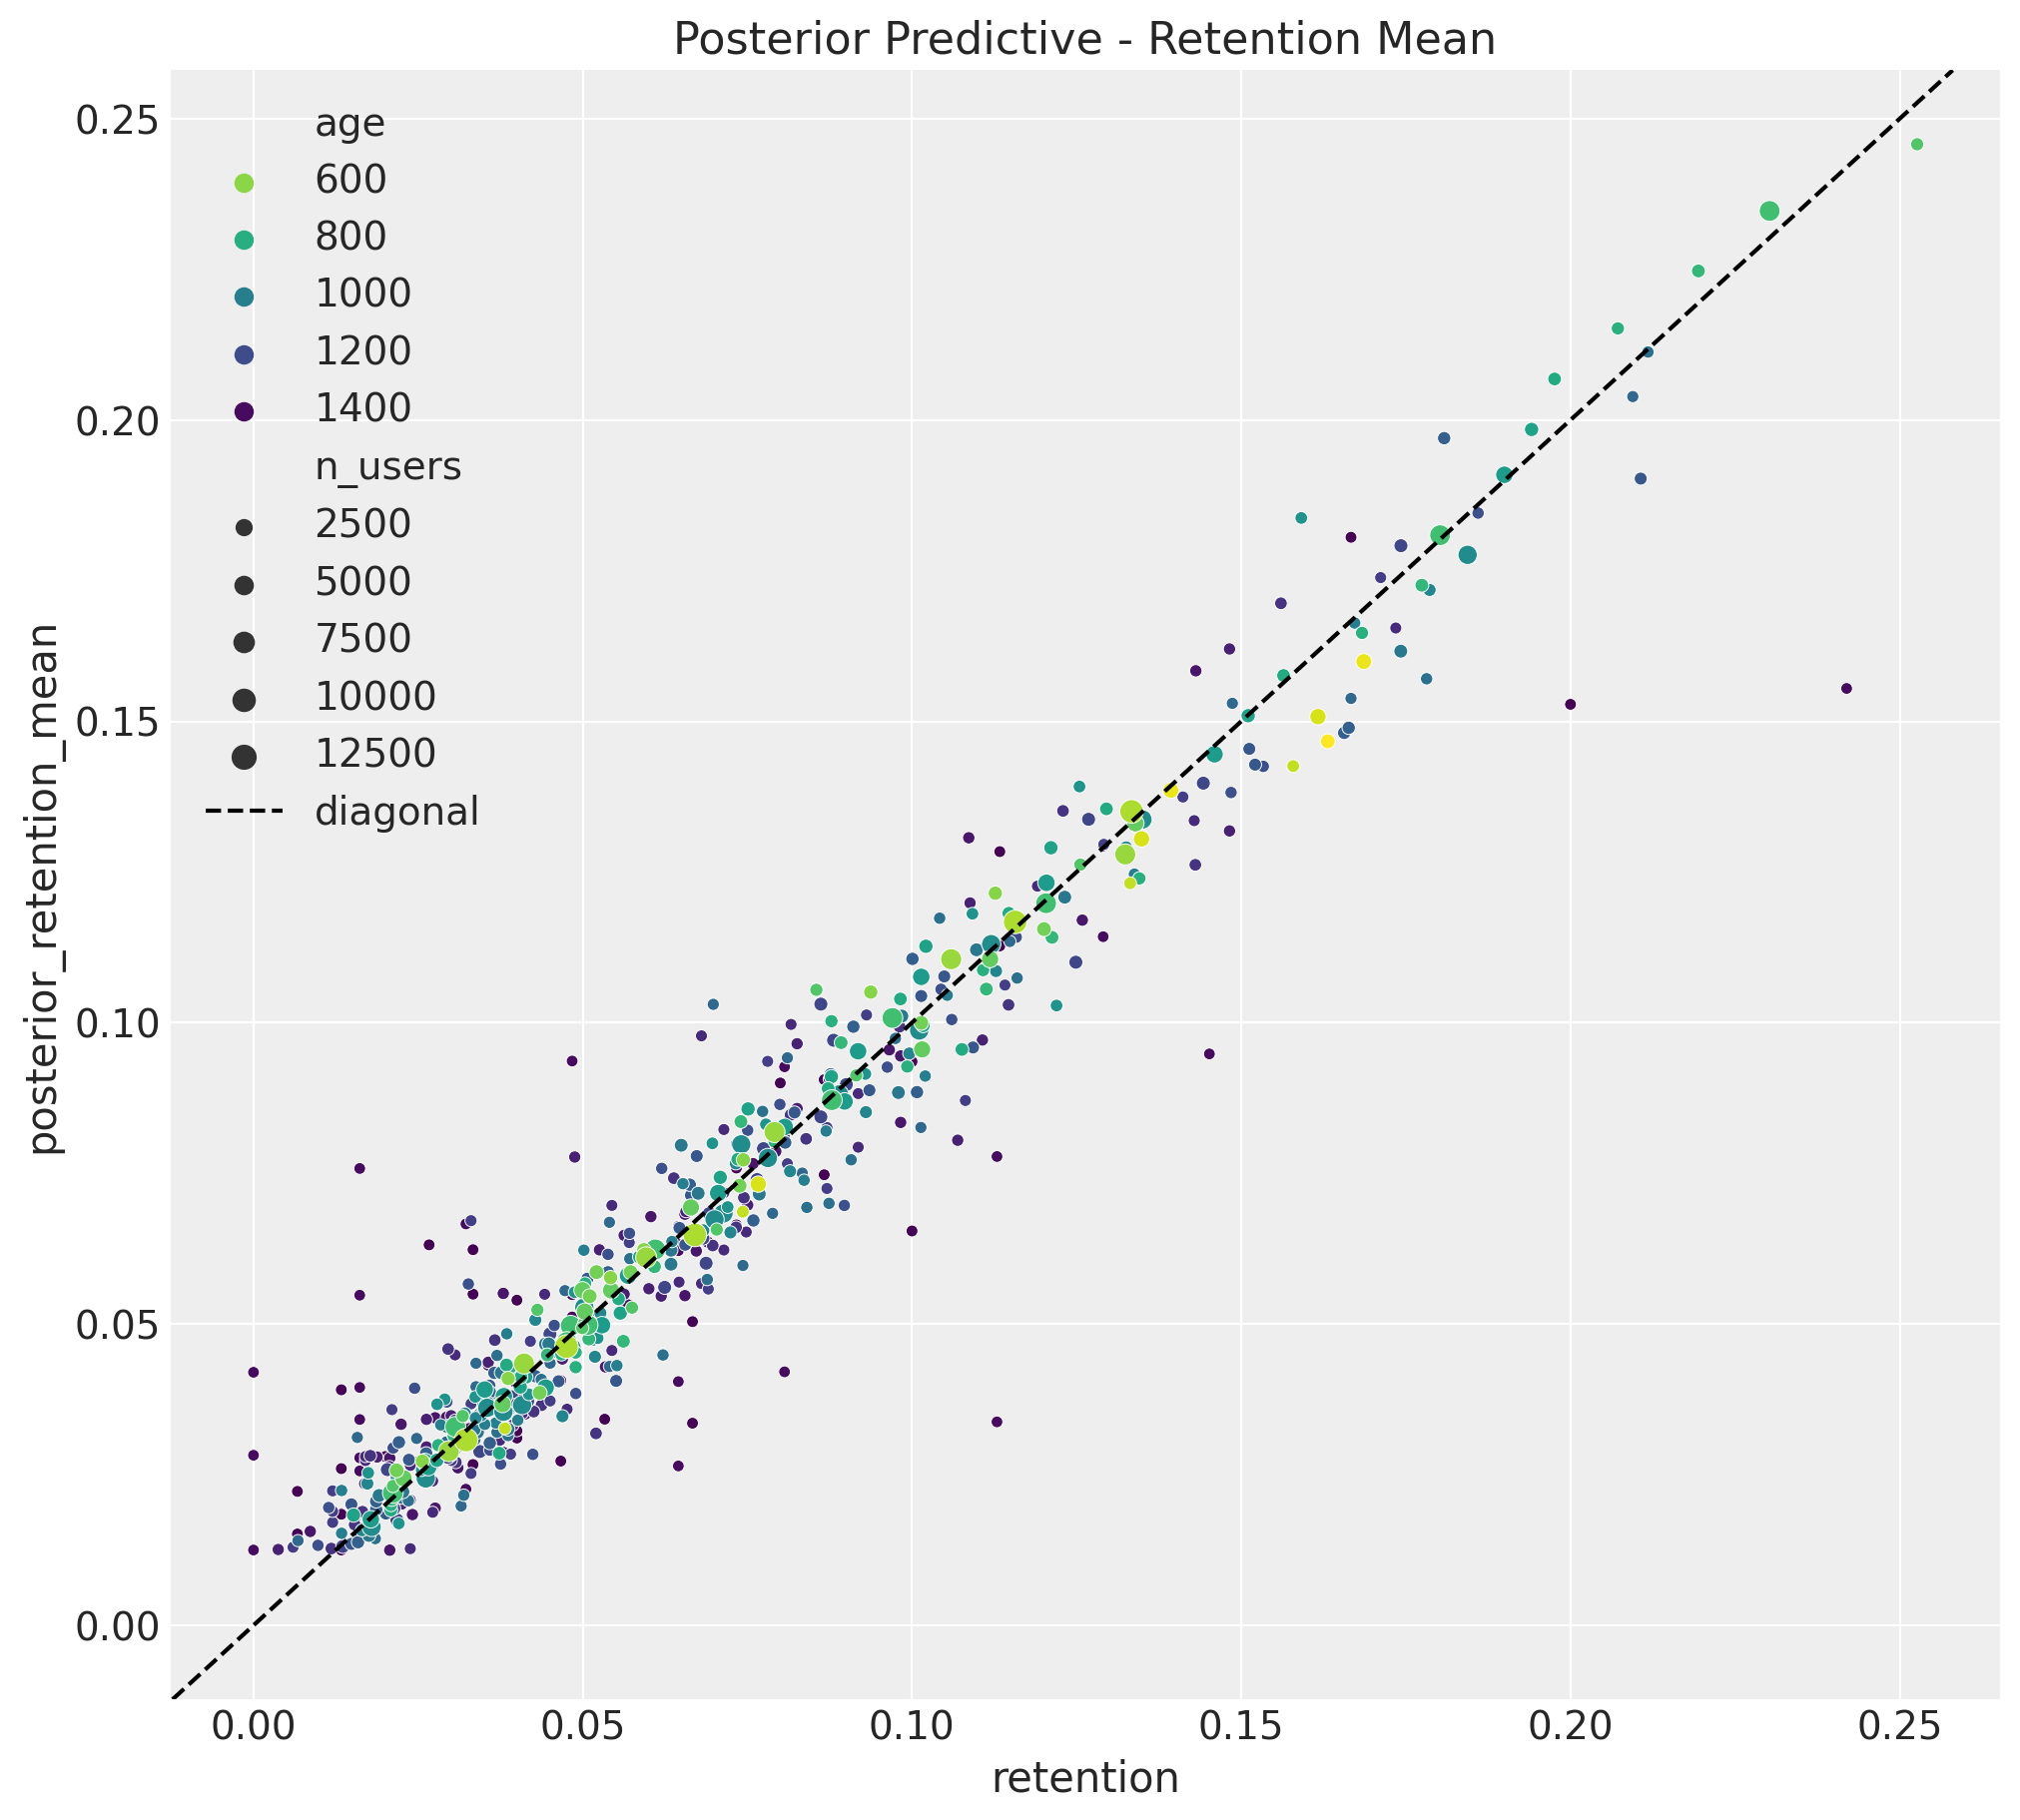

In [47]:
train_posterior_retention = (
    posterior_predictive.posterior_predictive / train_n_users[np.newaxis, None]
)
train_posterior_retention_mean = az.extract(
    data=train_posterior_retention, var_names=["likelihood"]
).mean("sample")

fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(
    x="retention",
    y="posterior_retention_mean",
    data=train_data_red_df.assign(
        posterior_retention_mean=train_posterior_retention_mean
    ),
    hue="age",
    palette="viridis_r",
    size="n_users",
    ax=ax,
)
ax.axline(xy1=(0, 0), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(title="Posterior Predictive - Retention Mean")


The results look quite good 🚀 !

Now, we can deep dive into specific cohorts to see the predictions and uncertainty of the estimates.

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_28497/3012353502.py:46: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


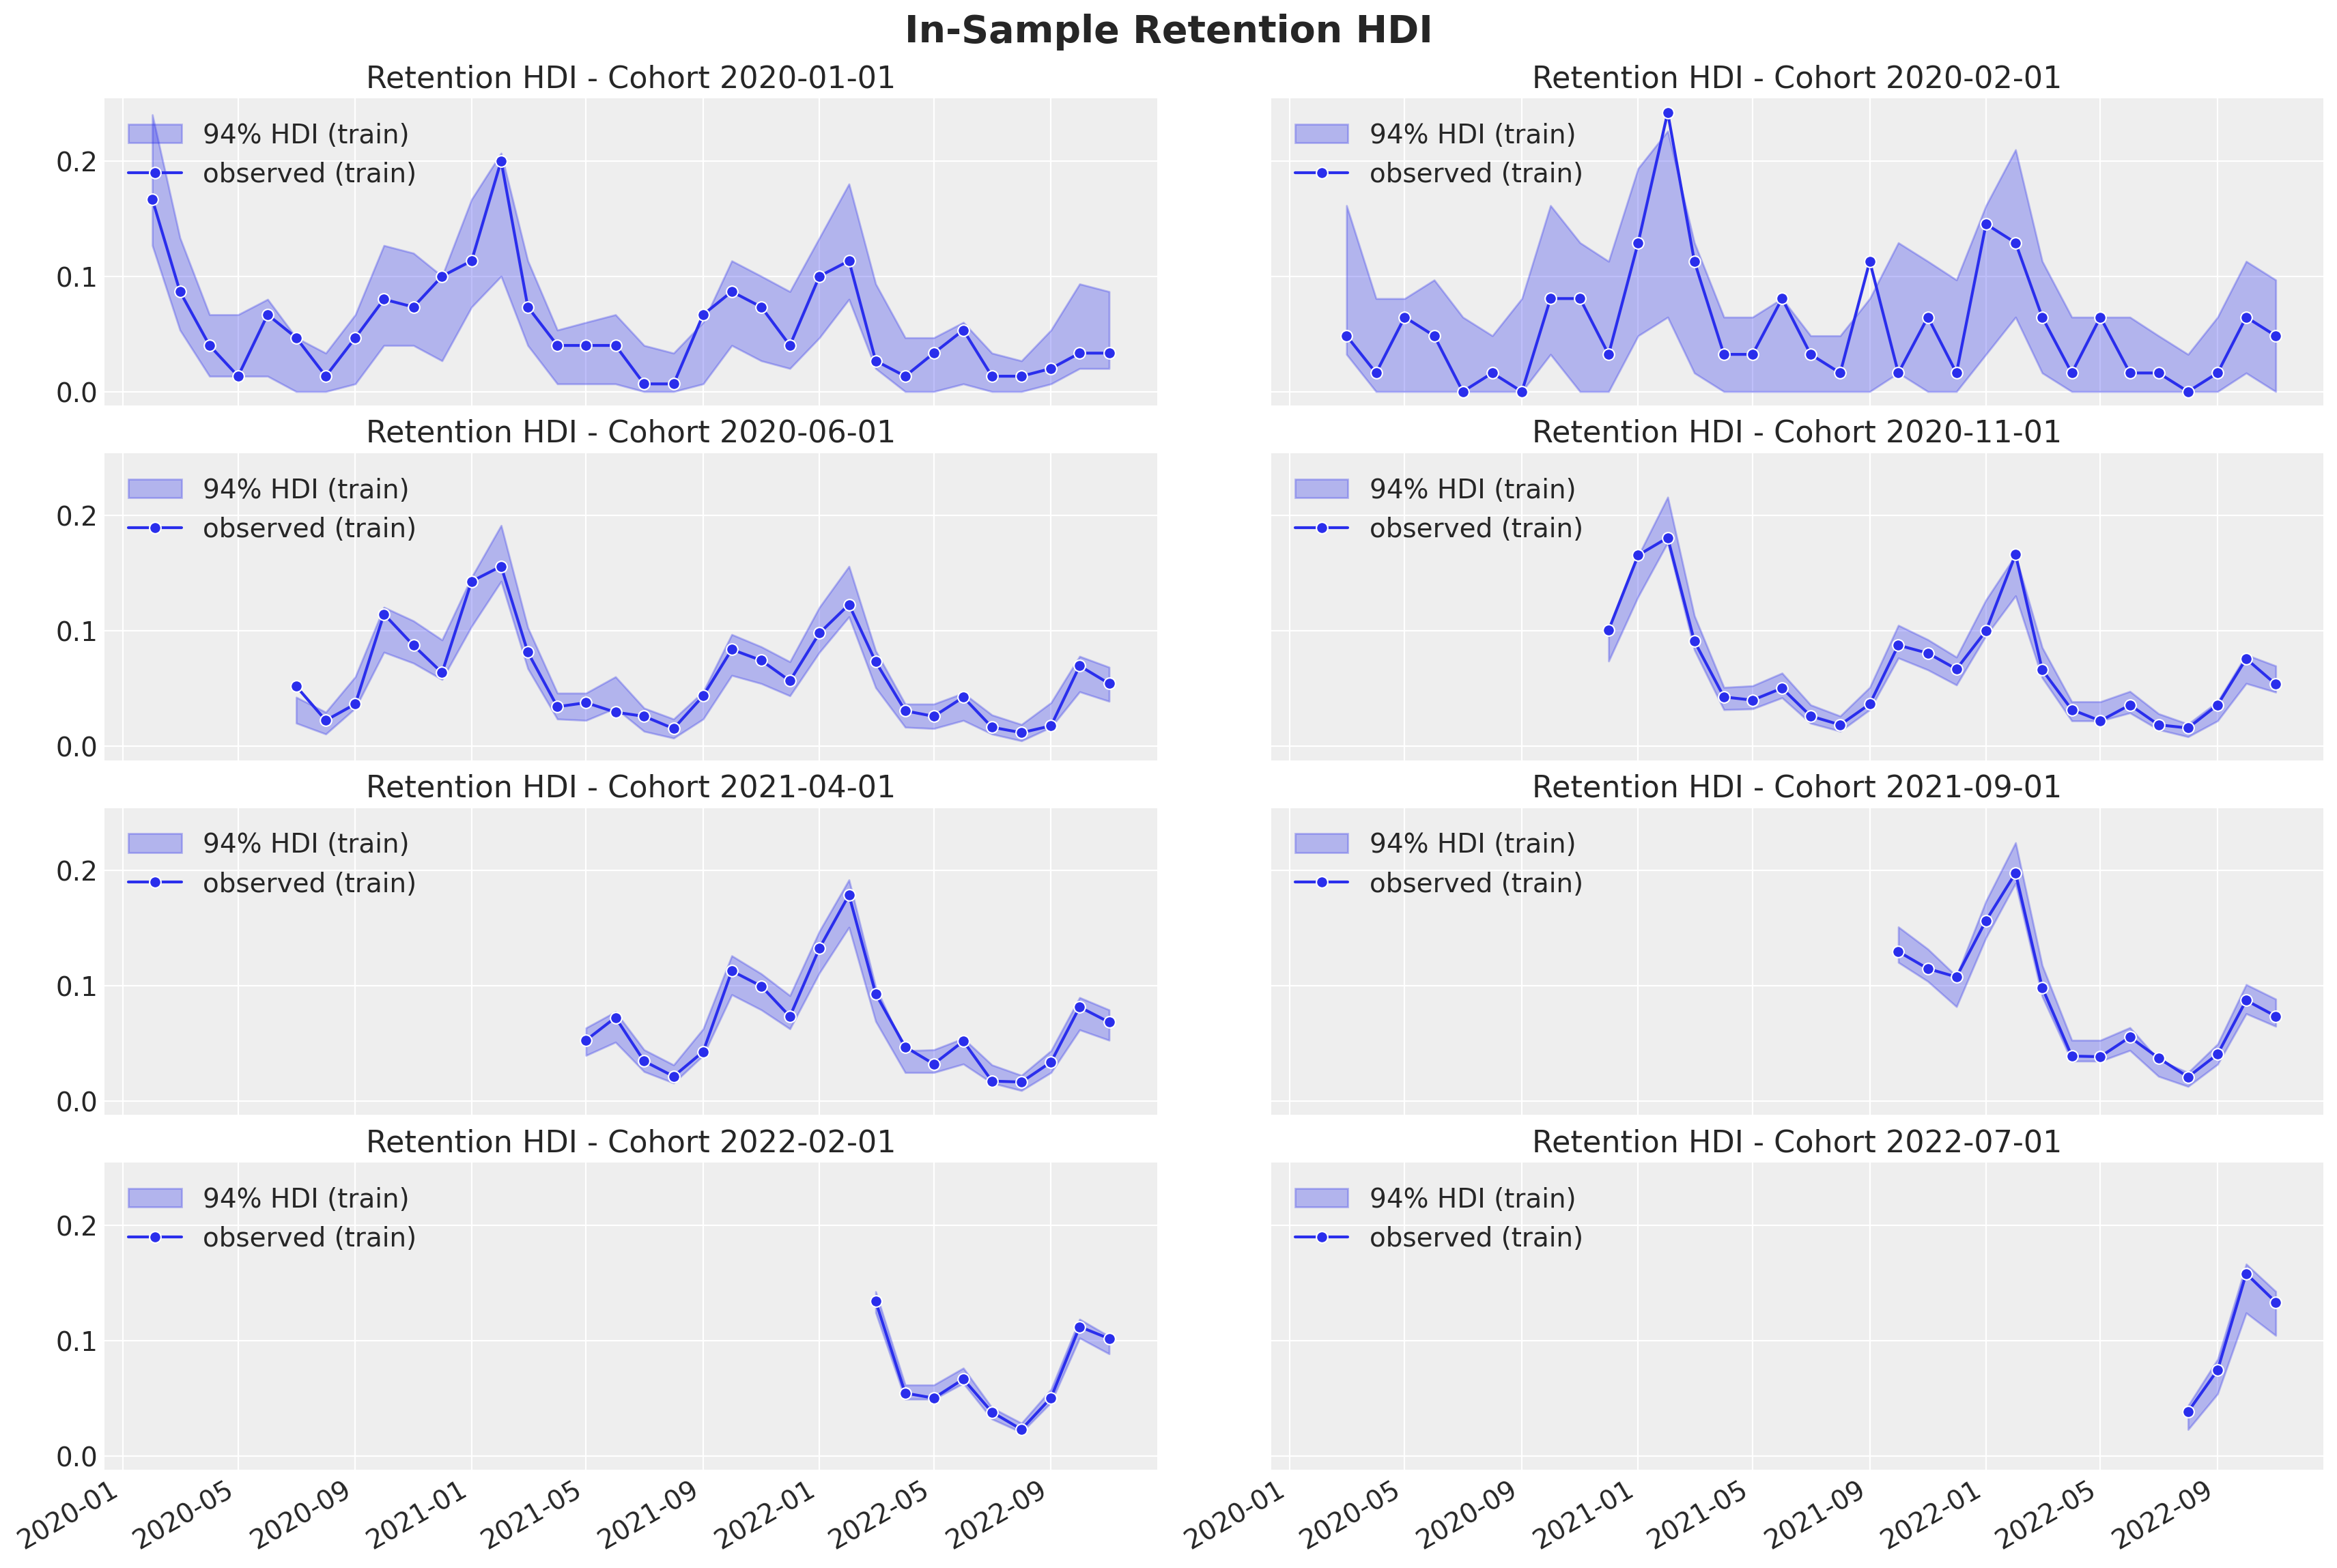

In [48]:
train_retention_hdi = az.hdi(ary=train_posterior_retention)["likelihood"]


def plot_train_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = train_cohort_idx == cohort_index

    ax.fill_between(
        x=train_period[train_period_idx[mask]],
        y1=train_retention_hdi[mask, :][:, 0],
        y2=train_retention_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C0",
        label="94% HDI (train)",
    )
    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=train_retention[mask],
        color="C0",
        marker="o",
        label="observed (train)",
        ax=ax,
    )
    cohort_name = (
        pd.to_datetime(train_cohort_encoder.classes_[cohort_index]).date().isoformat()
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Retention HDI - Cohort {cohort_name}")
    return ax


cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=np.ceil(len(cohort_index_to_plot) / 2).astype(int),
    ncols=2,
    figsize=(17, 11),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten()):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)

fig.suptitle("In-Sample Retention HDI", y=1.03, fontsize=20, fontweight="bold")
fig.autofmt_xdate()


Here we also see the model is capturing the retention rate development over time. In addition we see how older cohorts have a higher uncertainty estimation as the number of base users is lower than the new cohorts.

## Predictions

Now we transform the test data to the same format as the training data and use the model to predict the retention rates. Note that we are using the scalers and encoders from the training data.

### Data Transformations

In [49]:
test_data_red_df = test_data_df.query("cohort_age > 0")
test_data_red_df = test_data_red_df[
    test_data_red_df["cohort"].isin(train_data_red_df["cohort"].unique())
].reset_index(drop=True)
test_obs_idx = test_data_red_df.index.to_numpy()
test_n_users = test_data_red_df["n_users"].to_numpy()
test_n_active_users = test_data_red_df["n_active_users"].to_numpy()
test_retention = test_data_red_df["retention"].to_numpy()

# Continuous features
test_cohort = test_data_red_df["cohort"].to_numpy()
test_cohort_idx = train_cohort_encoder.transform(test_cohort).flatten()
test_age = test_data_red_df["age"].to_numpy()
test_age_scaled = train_age_scaler.transform(test_age.reshape(-1, 1)).flatten()
test_cohort_age = test_data_red_df["cohort_age"].to_numpy()
test_cohort_age_scaled = train_cohort_age_scaler.transform(
    test_cohort_age.reshape(-1, 1)
).flatten()

# Categorical features
test_period_month = test_data_red_df["period"].dt.month.to_numpy()
test_period_month_idx = train_period_month_encoder.fit_transform(
    test_period_month
).flatten()

### Out-of-Sample Posterior Predictions

We now replace the model data with the test data and generate posterior predictions.

In [50]:
with model:
    pm.set_data(
        new_data={
            "age_scaled": test_age_scaled,
            "cohort_age_scaled": test_cohort_age_scaled,
            "period_month_idx": test_period_month_idx,
            "n_users": test_n_users,
            "n_active_users": np.ones_like(
                test_n_active_users
            ),  # Dummy data to make coords work! We are not using this at prediction time!
        },
        coords={"obs": test_obs_idx},
    )
    idata.extend(
        pm.sample_posterior_predictive(
            trace=idata,
            var_names=["likelihood", "p", "mu"],
            idata_kwargs={"coords": {"obs": test_obs_idx}},
        )
    )

Sampling: [likelihood]


### Retention Rate Out-of-Sample Predictions

Finally we compute the posterior retention rate distributions for the test data and visualize the results.

In [51]:
test_posterior_retention = (
    idata.posterior_predictive["likelihood"] / test_n_users[np.newaxis, None]
)

test_retention_hdi = az.hdi(ary=test_posterior_retention)["likelihood"]

In [52]:
def plot_test_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = test_cohort_idx == cohort_index

    test_period_range = test_data_red_df.query(
        f"cohort == '{train_cohort_encoder.classes_[cohort_index]}'"
    )["period"]

    ax.fill_between(
        x=test_period_range,
        y1=test_retention_hdi[mask, :][:, 0],
        y2=test_retention_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C1",
        label="94% HDI (test)",
    )
    sns.lineplot(
        x=test_period_range,
        y=test_retention[mask],
        color="C1",
        marker="o",
        label="observed retention (test)",
        ax=ax,
    )
    return ax


Text(0.5, 1.03, 'Retention Predictions')

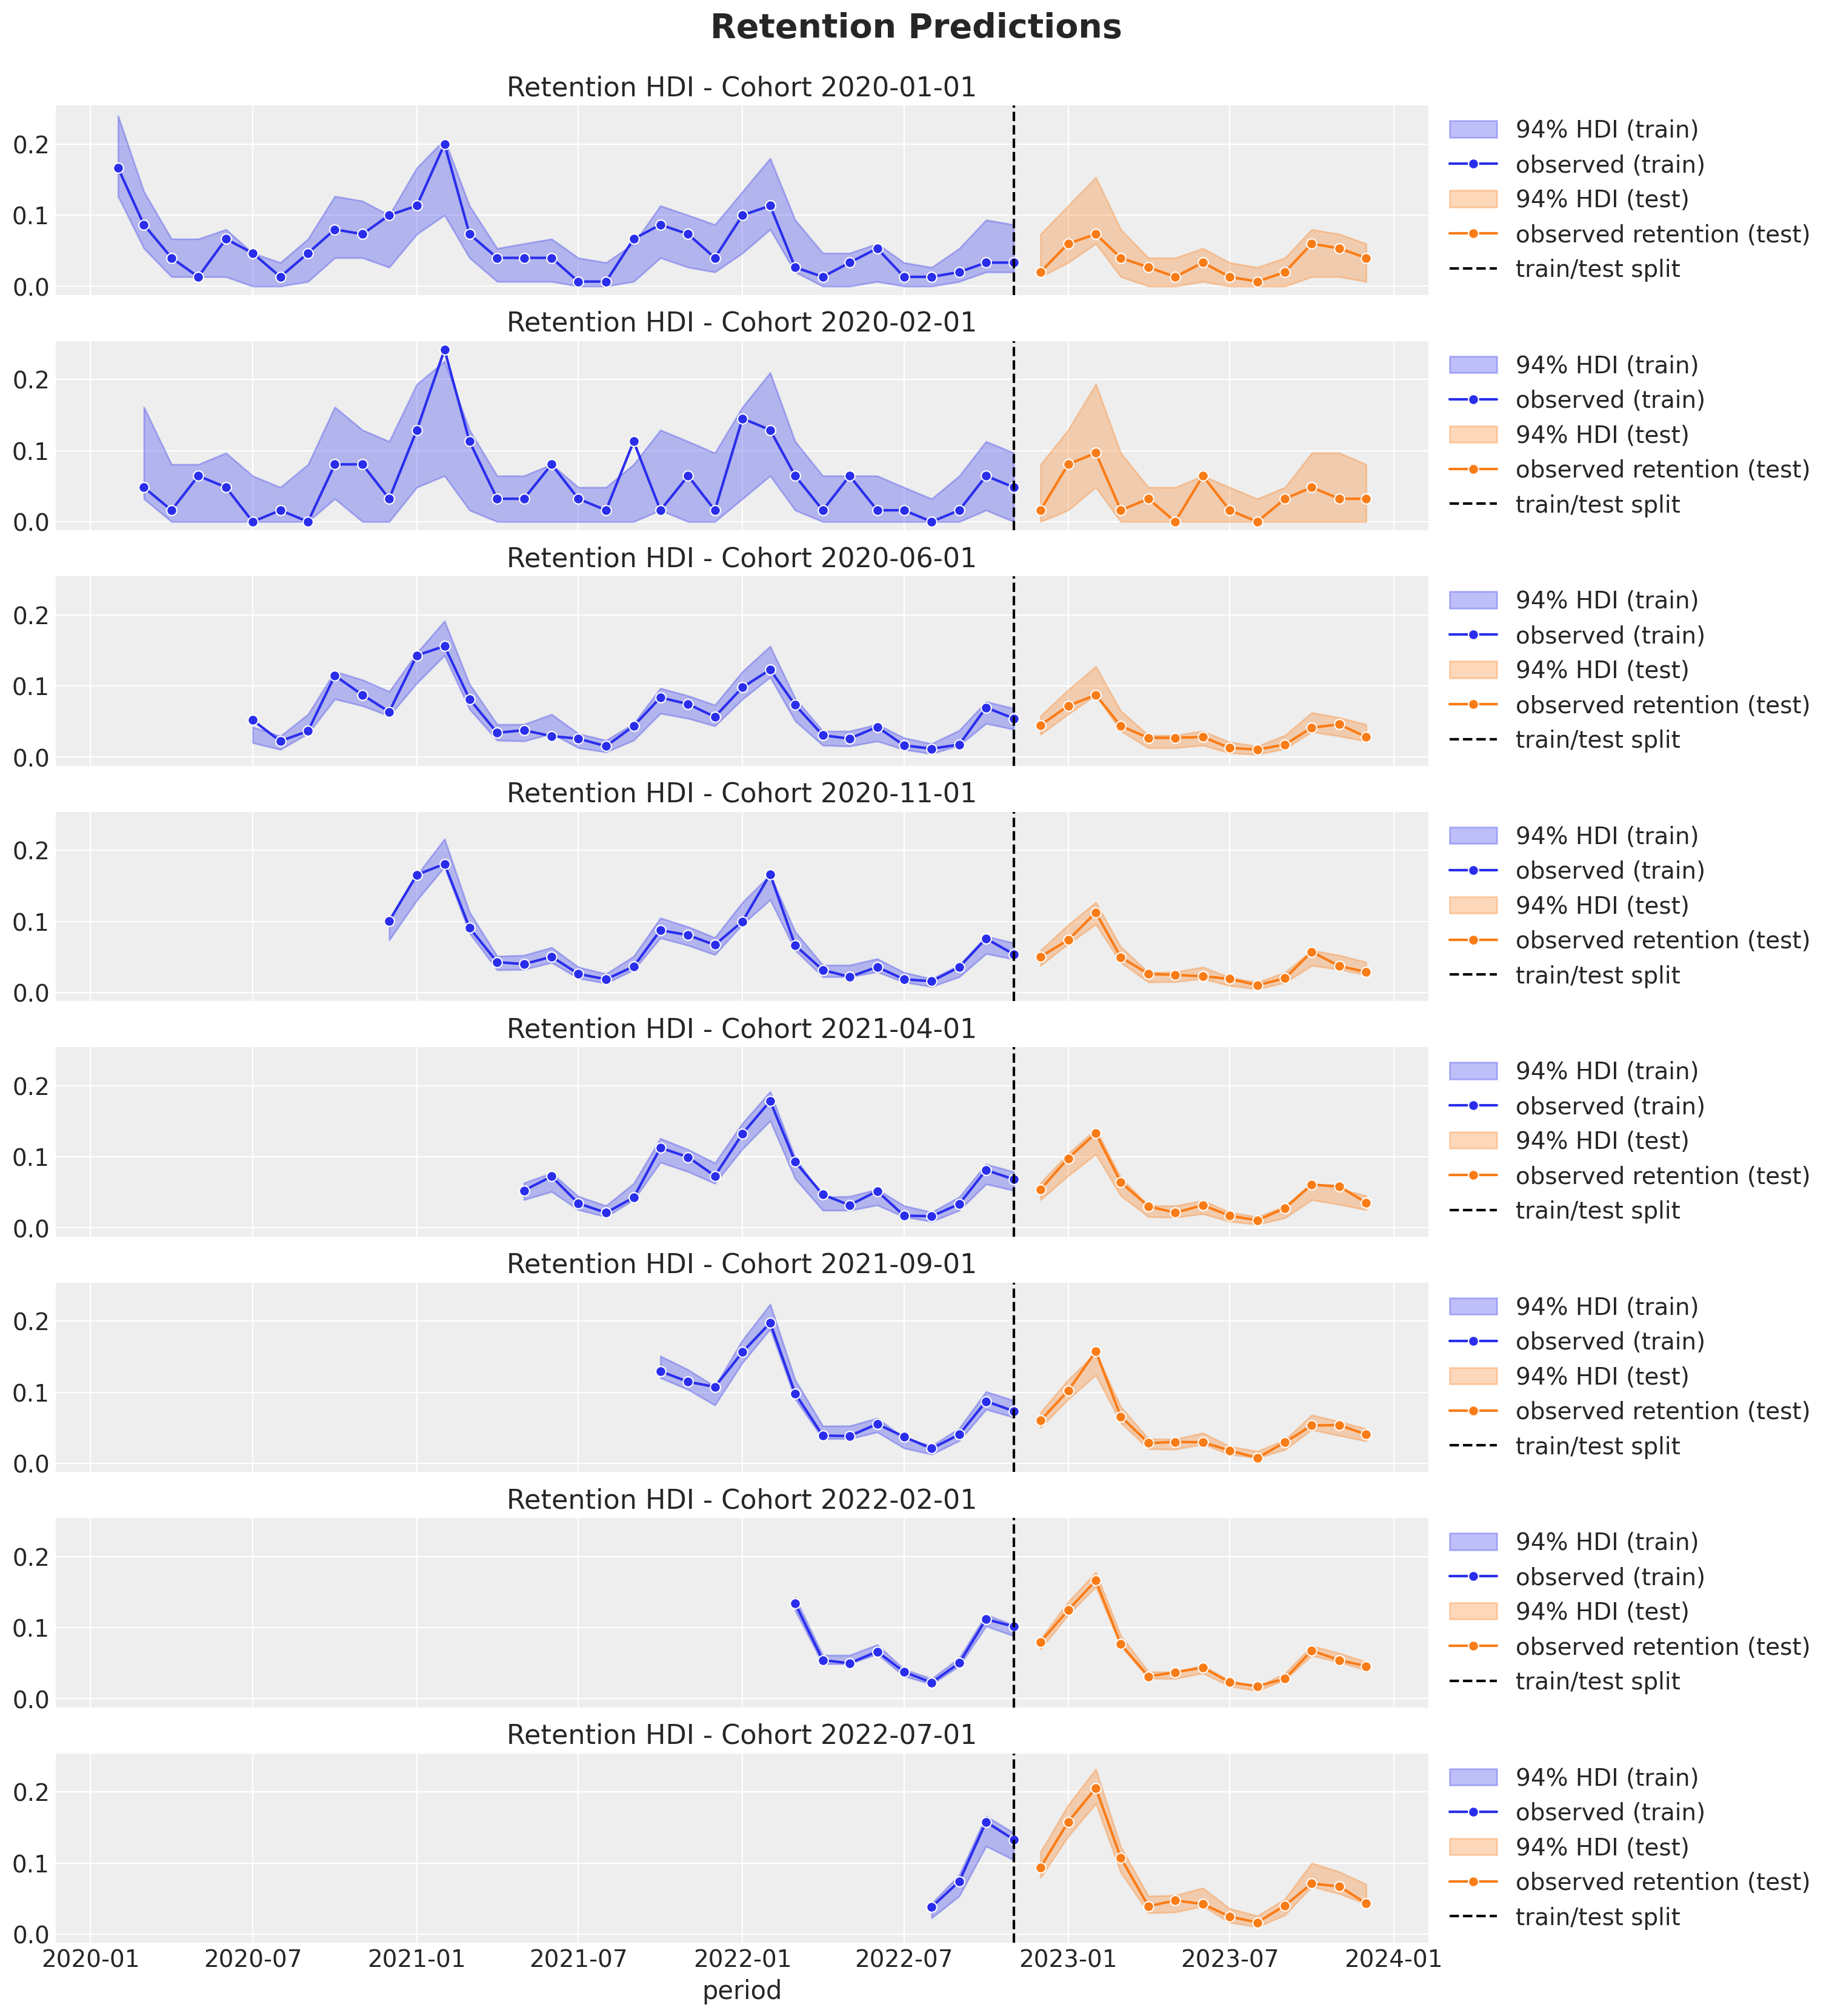

In [53]:
cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=len(cohort_index_to_plot),
    ncols=1,
    figsize=(15, 16),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten()):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    plot_test_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    ax.axvline(
        x=pd.to_datetime(period_train_test_split),
        color="black",
        linestyle="--",
        label="train/test split",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.suptitle("Retention Predictions", y=1.03, fontsize=20, fontweight="bold")

The out-of-sample predictions look quite good as well 🙌 ! 

For real data sets we expect this model to be a baseline for further improvements. For example, we could add more features (e.g. country, user segment, etc.) or we could use a more complex model (e.g. a hierarchical model).